# Problem description

You are to predict whether a company will go bankrupt in the following year, based on financial attributes of the company.

Perhaps you are contemplating lending money to a company, and need to know whether the company
is in near-term danger of not being able to repay.


## Goal

## Learning objectives

- Demonstrate mastery on solving a classification problem and presenting
the entire Recipe for Machine Learning process in a notebook.
- We will make suggestions for ways to approach the problem
    - But there will be little explicit direction for this task.
- It is meant to be analogous to a pre-interview task that a potential employer might assign
to verify your skill

# Import modules

In [374]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn

import os
import math

%matplotlib inline


# API for students

In [376]:
## Load the bankruptcy_helper module

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

# Import bankruptcy_helper module
import bankruptcy_helper
%aimport bankruptcy_helper

helper = bankruptcy_helper.Helper()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get the data

The first step in our Recipe is Get the Data.

- Each example is a row of data corresponding to a single company
- There are 64 attributes, described in the section below
- The column `Bankrupt` is 1 if the company subsequently went bankrupt; 0 if it did not go bankrupt
- The column `Id` is a Company Identifier

In [378]:
# Data directory
DATA_DIR = "./Data"

if not os.path.isdir(DATA_DIR):
    DATA_DIR = "../resource/asnlib/publicdata/bankruptcy/data"

data_file = "5th_yr.csv"
data = pd.read_csv( os.path.join(DATA_DIR, "train", data_file) )

target_attr = "Bankrupt"

n_samples, n_attrs = data.shape
print("Date shape: ", data.shape)

Date shape:  (4818, 66)


## Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek

In [380]:
data.head()

X1        X2       X3      X4       X5        X6         X7  \
0   0.025417   0.41769   0.0568  1.1605  -126.39   0.41355   0.025417   
1  -0.023834    0.2101  0.50839  4.2374   22.034  0.058412  -0.027621   
2   0.030515   0.44606  0.19569   1.565   35.766   0.28196   0.039264   
3   0.052318  0.056366  0.54562   10.68    438.2   0.13649   0.058164   
4   0.000992   0.49712  0.12316  1.3036  -71.398         0   0.001007   

        X8       X9      X10  ...        X57      X58       X59     X60  \
0   1.2395  1.16500  0.51773  ...   0.049094  0.85835   0.12322  5.6167   
1   3.6579  0.98183  0.76855  ...  -0.031011  1.01850  0.069047  5.7996   
2  0.88456  1.05260  0.39457  ...   0.077337  0.95006   0.25266  15.049   
3   10.853  1.02790  0.61173  ...   0.085524  0.97282         0  6.0157   
4   1.0116  1.29210  0.50288  ...   0.001974  0.99925  0.019736  3.4819   

      X61      X62     X63     X64  Bankrupt    Id  
0  7.4042  164.310  2.2214   1.334         0  4510  
1  7.7529   26.446  13.802  6.4782         0  3537  
2  2.8179  104.730  3.4852  2.6361         0  3920  
3  7.4626   48.756  7.4863  1.0602         0  1806  
4   8.582  114.580  3.1854   2.742         0  1529  

[5 rows x 66 columns]

Pretty *unhelpful* !

What are these mysteriously named features ?

## Description of attributes

This may still be somewhat unhelpful for those of you not used to reading Financial Statements.

But that's partially the point of the exercise
- You can *still* perform Machine Learning *even if* you are not an expert in the problem domain
    - That's what makes this a good interview exercise: you can demonstrate your thought process even if you don't know the exact meaning of the terms
- Of course: becoming an expert in the domain *will improve* your ability to create better models
    - Feature engineering is easier if you understand the features, their inter-relationships, and the relationship to the target

Let's get a feel for the data
- What is the type of each attribute ?


In [384]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4818 non-null   object 
 1   X2        4818 non-null   object 
 2   X3        4818 non-null   object 
 3   X4        4818 non-null   object 
 4   X5        4818 non-null   object 
 5   X6        4818 non-null   object 
 6   X7        4818 non-null   object 
 7   X8        4818 non-null   object 
 8   X9        4818 non-null   float64
 9   X10       4818 non-null   object 
 10  X11       4818 non-null   object 
 11  X12       4818 non-null   object 
 12  X13       4818 non-null   float64
 13  X14       4818 non-null   object 
 14  X15       4818 non-null   object 
 15  X16       4818 non-null   object 
 16  X17       4818 non-null   object 
 17  X18       4818 non-null   object 
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4818 non-null   obje

You may be puzzled:
- Most attributes are `object` and *not* numeric (`float64`)
- But looking at the data via `data.head()` certainly gives the impression that all attributes are numeric

Welcome to the world of messy data !  The dataset has represented numbers as strings.
- These little unexpected challenges are common in the real-word
- Data is rarely perfect and clean

So you might want to first convert all attributes to numeric

**Hint**
- Look up the Pandas method `to_numeric`
    - We suggest you use the option `errors='coerce'`
    

# Evaluating your project

We will evaluate your submission on a test dataset that we provide
- It has no labels, so **you** can't use it to evaluate your model, but **we** have the labels
- We will call this evaluation dataset the "holdout" data

Let's get it

In [389]:
holdout_data = pd.read_csv( os.path.join(DATA_DIR, "holdout", '5th_yr.csv') )

print("Data shape: ", holdout_data.shape)

Data shape:  (1092, 65)


We will evaluate your model on the holdout examples using metrics
- Accuracy
- Recall
- Precision

From our lecture: we may have to make a trade-off between Recall and Precision.

Our evaluation of your submission will be partially based on how you made (and described) the trade-off.

You may assume that it is 5 times worse to *fail to identify a company that will go bankrupt*
than it is to fail to identify a company that won't go bankrupt.

# Your model

Time for you to continue the Recipe for Machine Learning on your own.



Let's do data exploratory analysis to understand the underlying pattern of the data, feature correlation, and deal with possible issues like missing value.

First, we should transform the data in object into float64 for easier analysis

In [394]:
for col in data.columns:
    if data[col].dtype == 'object':  
        data[col] = pd.to_numeric(data[col], errors='coerce')
        
print(data.dtypes)

X1          float64
X2          float64
X3          float64
X4          float64
X5          float64
             ...   
X62         float64
X63         float64
X64         float64
Bankrupt      int64
Id            int64
Length: 66, dtype: object


In [395]:
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
df_copy = data.copy()

Heatmap of Missing Data

<Figure size 640x480 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Heatmap of Missing Data')

Text(0.5, 23.52222222222222, 'Features')

Text(50.722222222222214, 0.5, 'Data Points')

([], [])

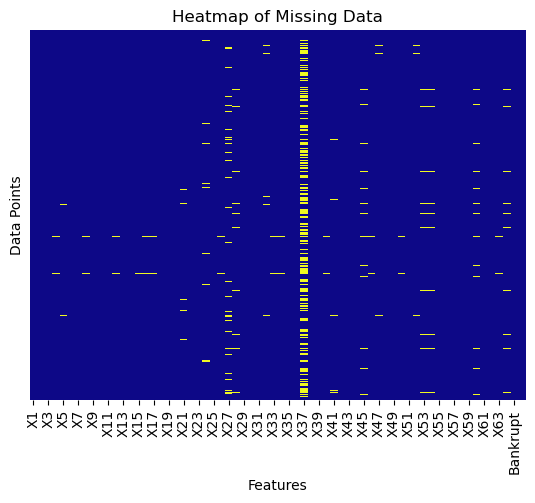

In [397]:
null_values = df_copy.isnull()

plt.figure()
sns.heatmap(null_values, cmap="plasma", cbar=False)
plt.title("Heatmap of Missing Data")
plt.xlabel("Features")
plt.ylabel("Data Points")
plt.yticks([])
plt.show()

In [398]:
missing_counts = df_copy.isna().sum()
print("Count of missing values per feature:")
print(missing_counts)

null_threshold = df_copy.shape[0] * 0.4
cols_with_high_missing = df_copy.columns[df_copy.isna().sum() > null_threshold]

print("Features with more than 40% missing data:")
print(cols_with_high_missing)

Count of missing values per feature:
X1           2
X2           2
X3           2
X4          15
X5          10
            ..
X62          0
X63         15
X64         83
Bankrupt     0
Id           0
Length: 66, dtype: int64
Features with more than 40% missing data:
Index(['X37'], dtype='object')


Identify outliers

<Figure size 1000x600 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X1'>

Text(0.5, 1.0, 'Boxplot of X1')

<Figure size 1000x600 with 0 Axes>

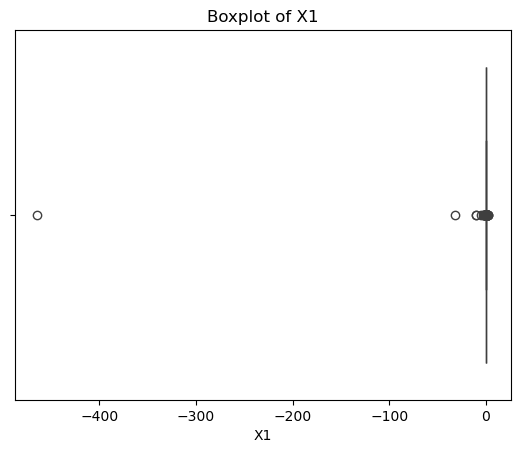

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X2'>

Text(0.5, 1.0, 'Boxplot of X2')

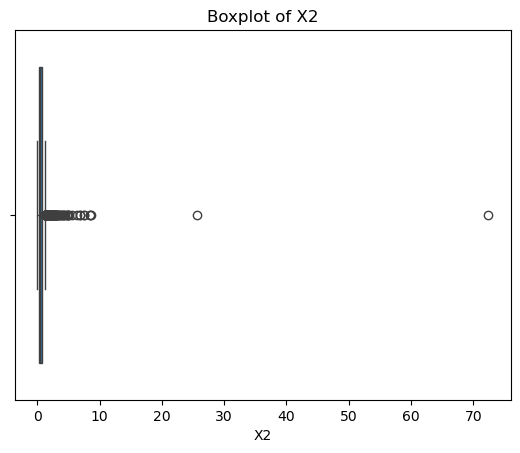

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X3'>

Text(0.5, 1.0, 'Boxplot of X3')

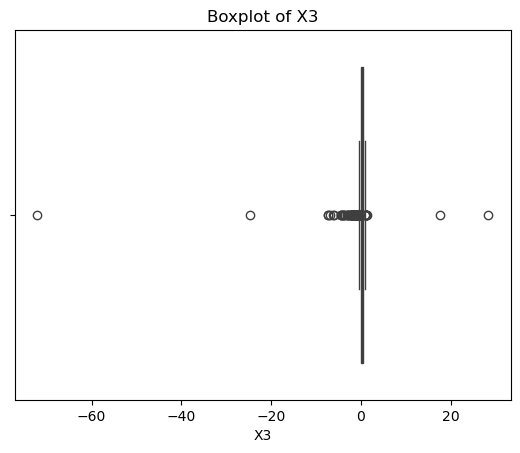

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X4'>

Text(0.5, 1.0, 'Boxplot of X4')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X5'>

Text(0.5, 1.0, 'Boxplot of X5')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X6'>

Text(0.5, 1.0, 'Boxplot of X6')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X7'>

Text(0.5, 1.0, 'Boxplot of X7')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X8'>

Text(0.5, 1.0, 'Boxplot of X8')

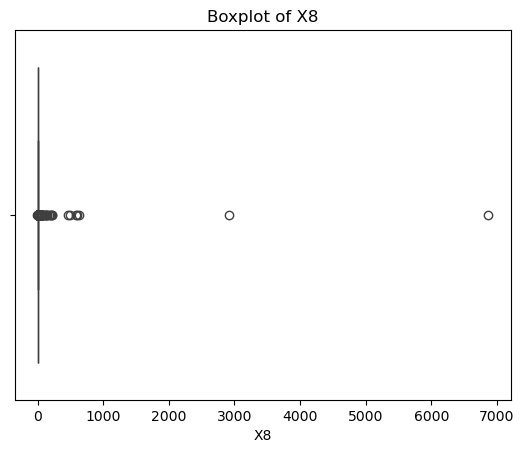

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X9'>

Text(0.5, 1.0, 'Boxplot of X9')

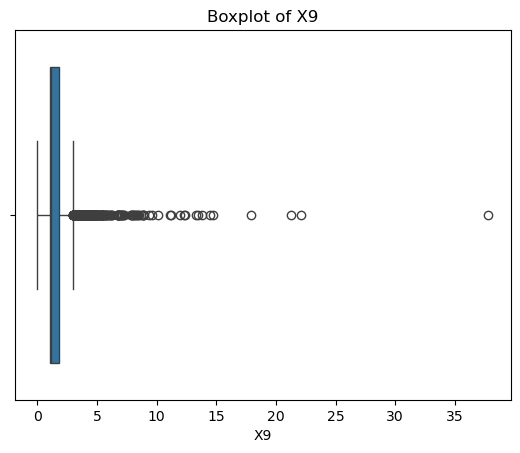

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X10'>

Text(0.5, 1.0, 'Boxplot of X10')

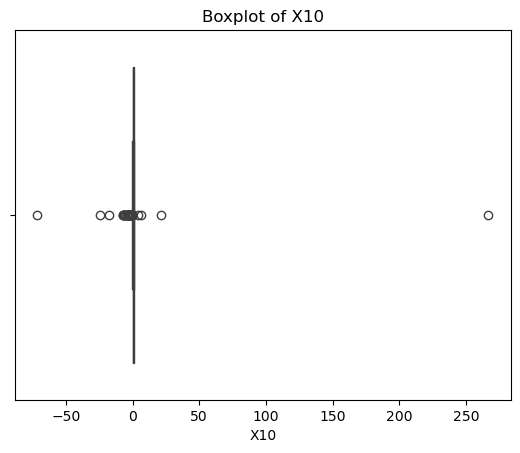

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X11'>

Text(0.5, 1.0, 'Boxplot of X11')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X12'>

Text(0.5, 1.0, 'Boxplot of X12')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X13'>

Text(0.5, 1.0, 'Boxplot of X13')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X14'>

Text(0.5, 1.0, 'Boxplot of X14')

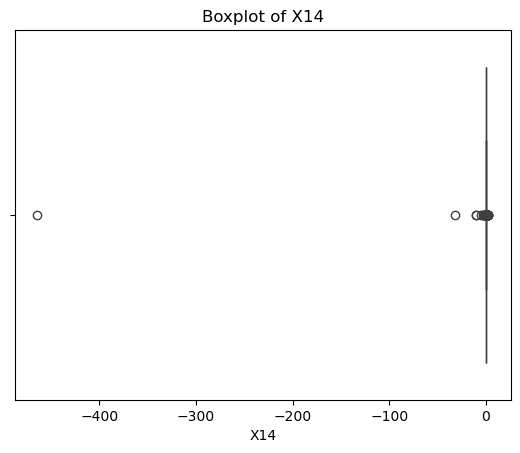

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X15'>

Text(0.5, 1.0, 'Boxplot of X15')

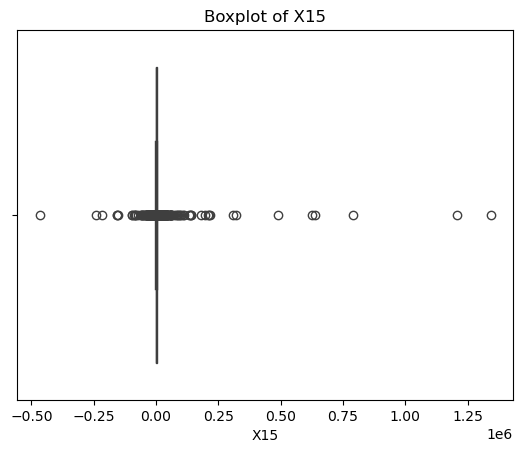

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X16'>

Text(0.5, 1.0, 'Boxplot of X16')

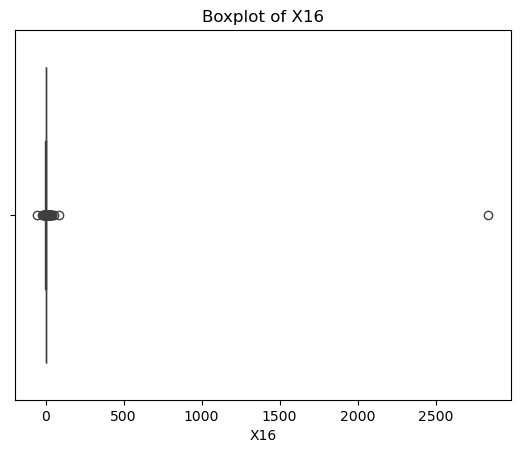

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X17'>

Text(0.5, 1.0, 'Boxplot of X17')

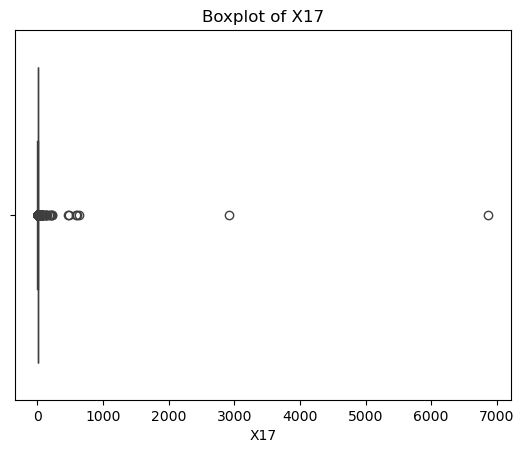

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X18'>

Text(0.5, 1.0, 'Boxplot of X18')

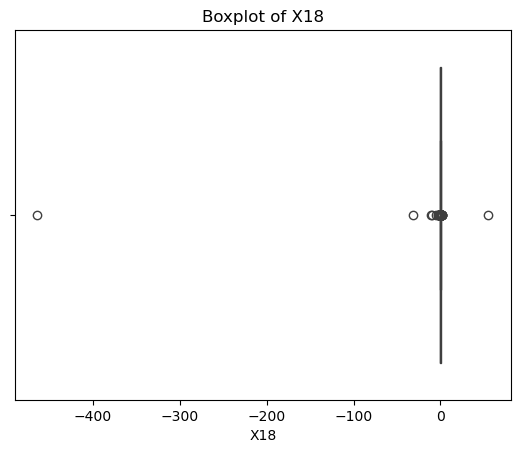

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X19'>

Text(0.5, 1.0, 'Boxplot of X19')

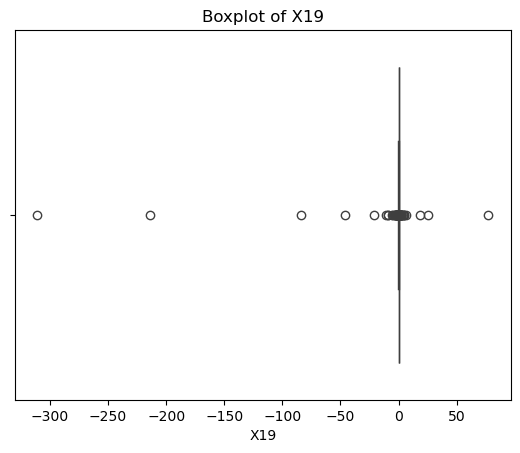

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X20'>

Text(0.5, 1.0, 'Boxplot of X20')

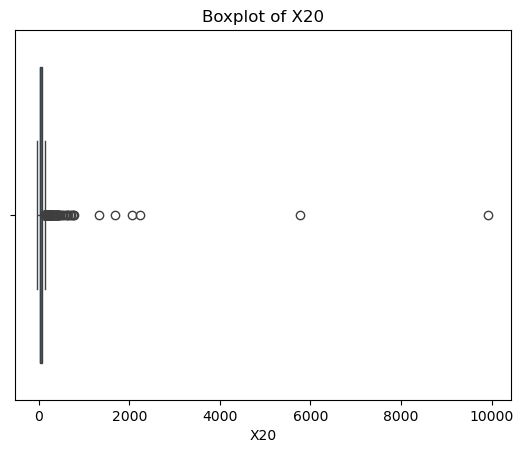

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X21'>

Text(0.5, 1.0, 'Boxplot of X21')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X22'>

Text(0.5, 1.0, 'Boxplot of X22')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X23'>

Text(0.5, 1.0, 'Boxplot of X23')

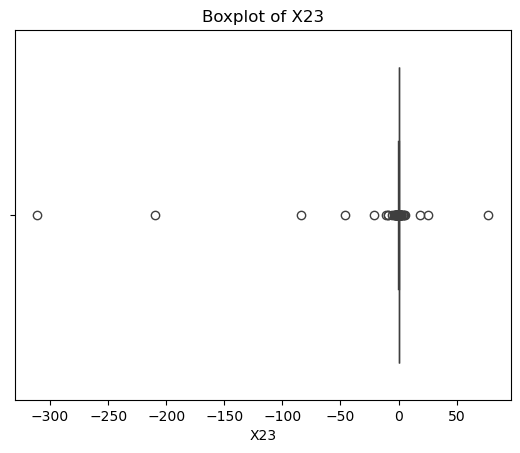

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X24'>

Text(0.5, 1.0, 'Boxplot of X24')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X25'>

Text(0.5, 1.0, 'Boxplot of X25')

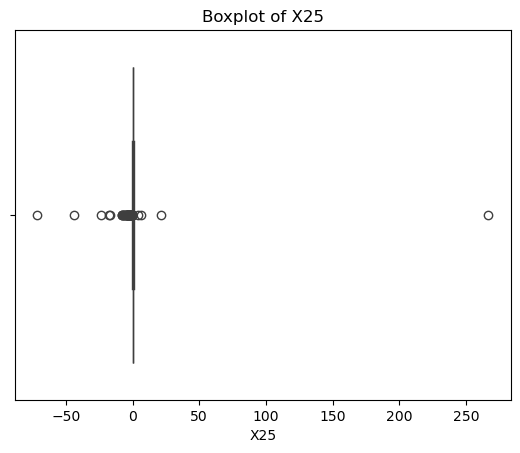

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X26'>

Text(0.5, 1.0, 'Boxplot of X26')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X27'>

Text(0.5, 1.0, 'Boxplot of X27')

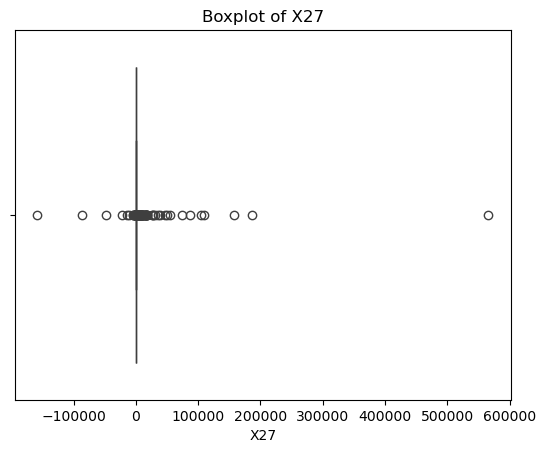

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X28'>

Text(0.5, 1.0, 'Boxplot of X28')

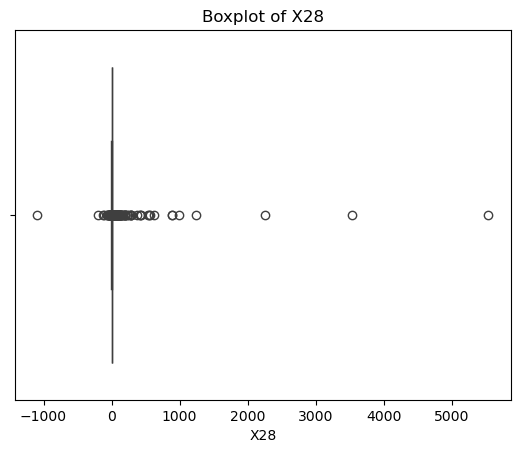

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X29'>

Text(0.5, 1.0, 'Boxplot of X29')

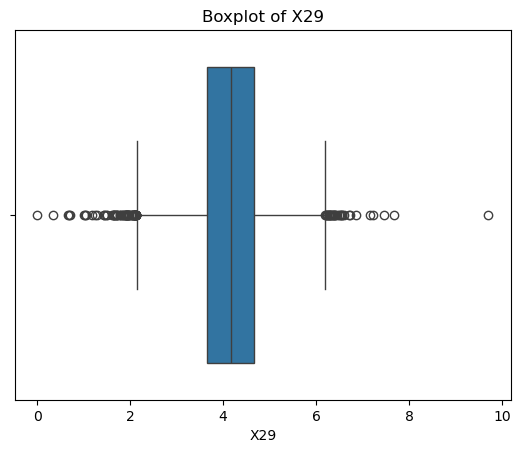

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X30'>

Text(0.5, 1.0, 'Boxplot of X30')

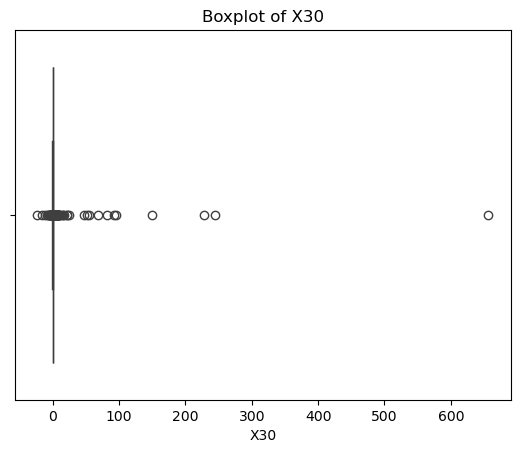

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X31'>

Text(0.5, 1.0, 'Boxplot of X31')

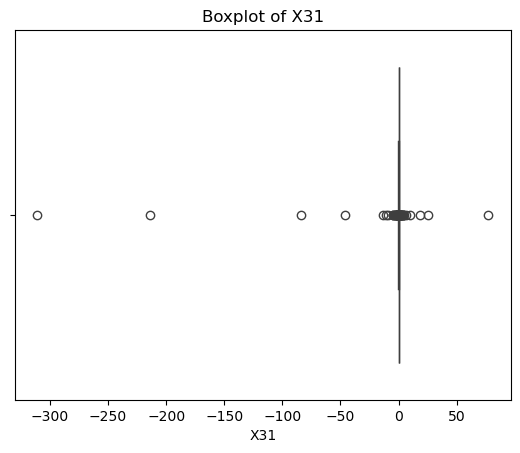

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X32'>

Text(0.5, 1.0, 'Boxplot of X32')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X33'>

Text(0.5, 1.0, 'Boxplot of X33')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X34'>

Text(0.5, 1.0, 'Boxplot of X34')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X35'>

Text(0.5, 1.0, 'Boxplot of X35')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X36'>

Text(0.5, 1.0, 'Boxplot of X36')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X37'>

Text(0.5, 1.0, 'Boxplot of X37')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X38'>

Text(0.5, 1.0, 'Boxplot of X38')

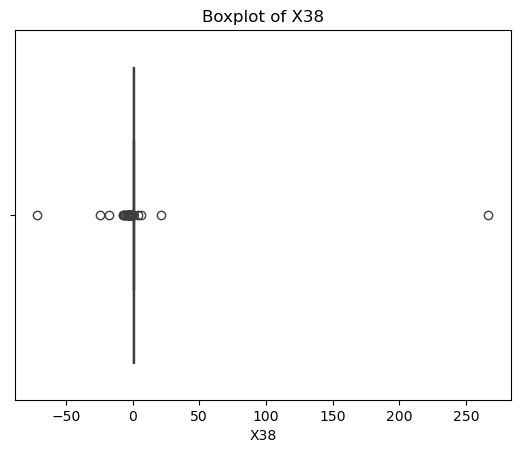

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X39'>

Text(0.5, 1.0, 'Boxplot of X39')

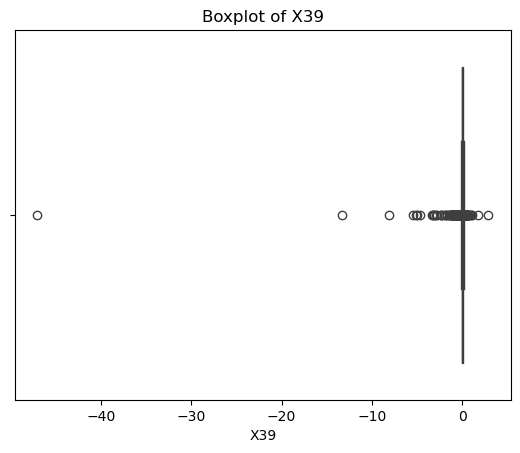

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X40'>

Text(0.5, 1.0, 'Boxplot of X40')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X41'>

Text(0.5, 1.0, 'Boxplot of X41')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X42'>

Text(0.5, 1.0, 'Boxplot of X42')

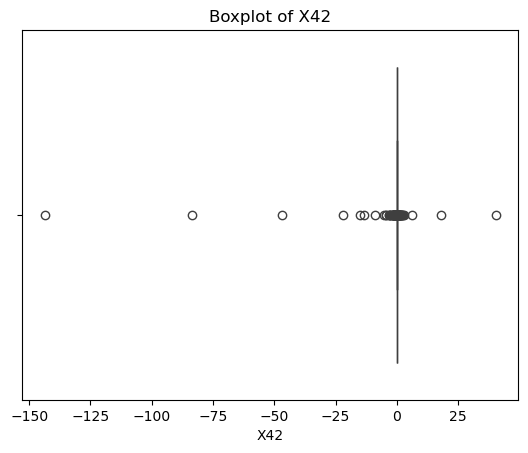

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X43'>

Text(0.5, 1.0, 'Boxplot of X43')

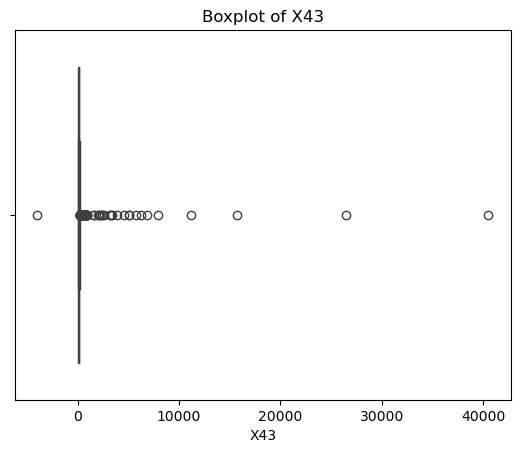

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X44'>

Text(0.5, 1.0, 'Boxplot of X44')

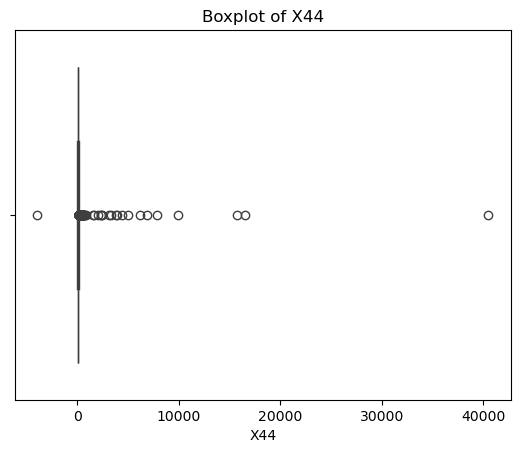

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X45'>

Text(0.5, 1.0, 'Boxplot of X45')

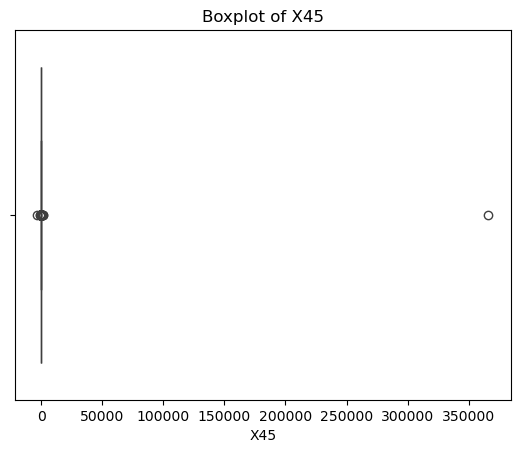

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X46'>

Text(0.5, 1.0, 'Boxplot of X46')

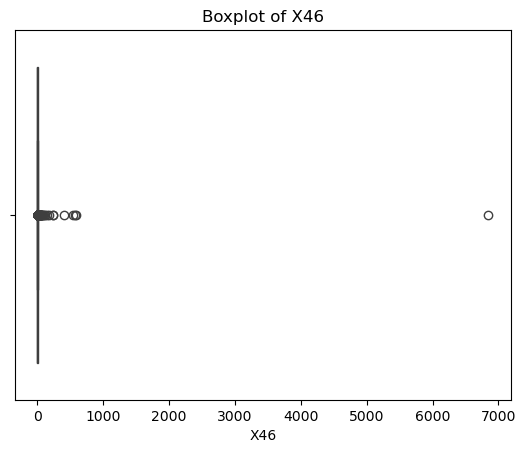

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X47'>

Text(0.5, 1.0, 'Boxplot of X47')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X48'>

Text(0.5, 1.0, 'Boxplot of X48')

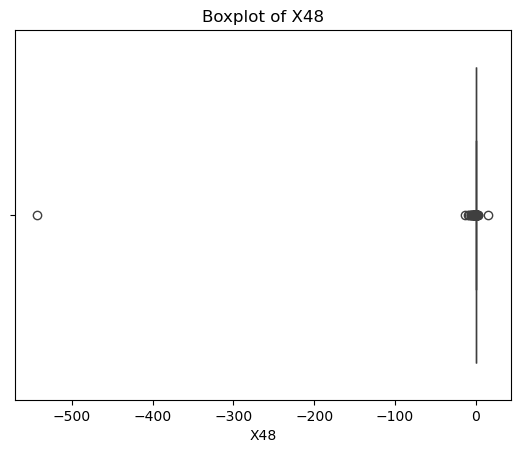

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X49'>

Text(0.5, 1.0, 'Boxplot of X49')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X50'>

Text(0.5, 1.0, 'Boxplot of X50')

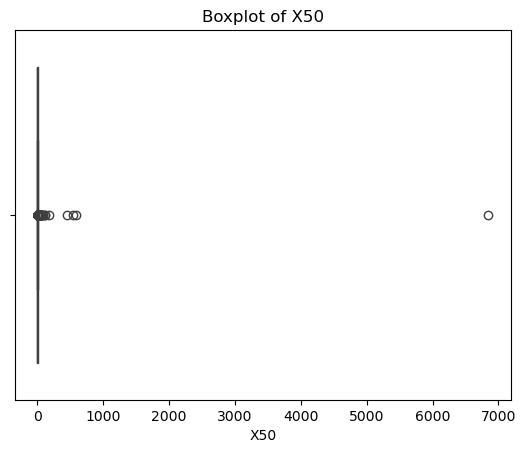

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X51'>

Text(0.5, 1.0, 'Boxplot of X51')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X52'>

Text(0.5, 1.0, 'Boxplot of X52')

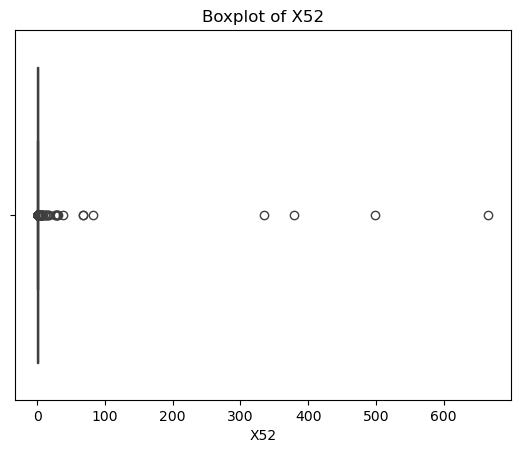

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X53'>

Text(0.5, 1.0, 'Boxplot of X53')

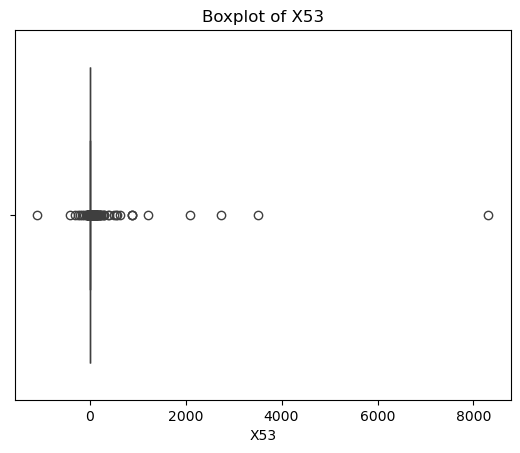

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X54'>

Text(0.5, 1.0, 'Boxplot of X54')

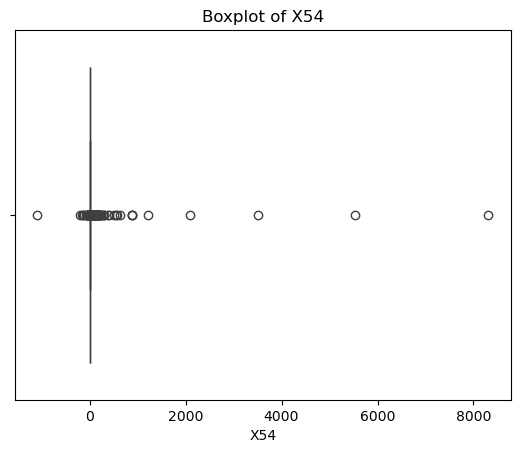

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X55'>

Text(0.5, 1.0, 'Boxplot of X55')

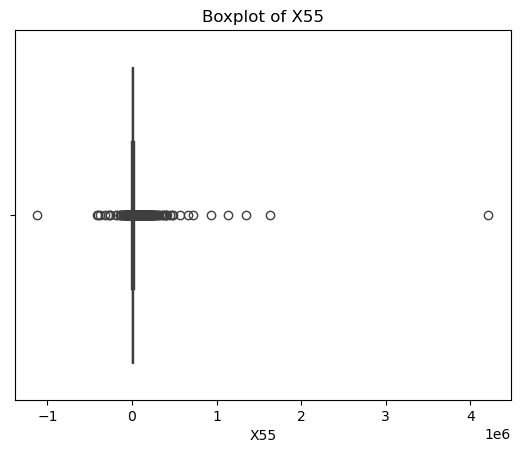

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X56'>

Text(0.5, 1.0, 'Boxplot of X56')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X57'>

Text(0.5, 1.0, 'Boxplot of X57')

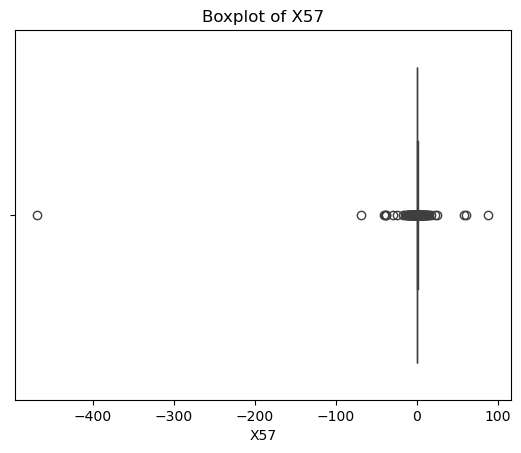

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X58'>

Text(0.5, 1.0, 'Boxplot of X58')

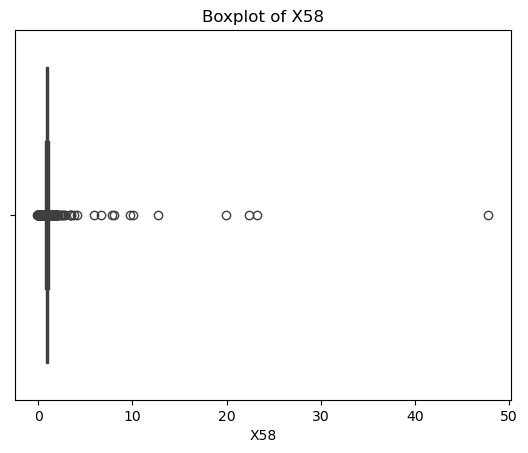

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X59'>

Text(0.5, 1.0, 'Boxplot of X59')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X60'>

Text(0.5, 1.0, 'Boxplot of X60')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X61'>

Text(0.5, 1.0, 'Boxplot of X61')

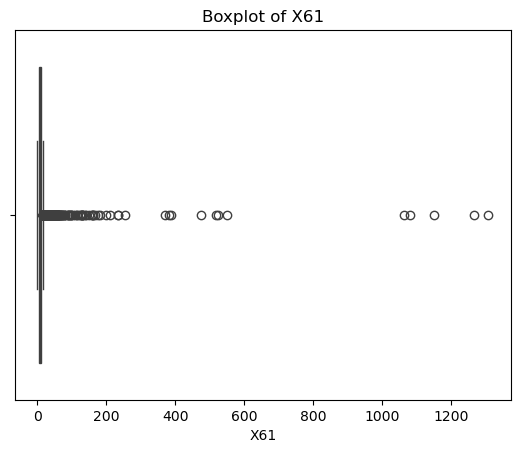

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X62'>

Text(0.5, 1.0, 'Boxplot of X62')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X63'>

Text(0.5, 1.0, 'Boxplot of X63')

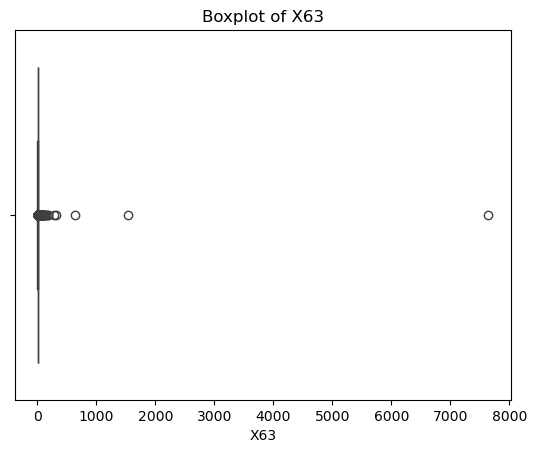

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X64'>

Text(0.5, 1.0, 'Boxplot of X64')

In [400]:
plt.figure(figsize=(10, 6))
for i, col in enumerate(df_copy.columns[:-2]):
        plt.figure(i) 
        sns.boxplot(x=df_copy[col]) 
        plt.title(f'Boxplot of {col}')
        plt.show() 

In [401]:
def find_outliers_iqr(df):
    outliers = {}
    for col in df.columns[:-2]:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    
    return outliers

outliers_iqr = find_outliers_iqr(df_copy)

for col, outlier_vals in outliers_iqr.items():
    print(f'Outliers in {col}:\n{outlier_vals}\n')

Outliers in X1:
Series([], Name: X1, dtype: float64)

Outliers in X2:
Series([], Name: X2, dtype: float64)

Outliers in X3:
Series([], Name: X3, dtype: float64)

Outliers in X4:
Series([], Name: X4, dtype: float64)

Outliers in X5:
Series([], Name: X5, dtype: float64)

Outliers in X6:
Series([], Name: X6, dtype: float64)

Outliers in X7:
Series([], Name: X7, dtype: float64)

Outliers in X8:
Series([], Name: X8, dtype: float64)

Outliers in X9:
18      3.3724
32      3.2033
33      3.2731
48      4.1140
62      3.1588
         ...  
4780    4.6143
4801    3.3558
4806    3.2234
4816    6.0718
4817    3.1990
Name: X9, Length: 368, dtype: float64

Outliers in X10:
Series([], Name: X10, dtype: float64)

Outliers in X11:
Series([], Name: X11, dtype: float64)

Outliers in X12:
Series([], Name: X12, dtype: float64)

Outliers in X13:
30       -0.17016
31        0.37911
46       -0.25554
53        0.34212
55       -0.96118
          ...    
4793     -0.37119
4798     -0.27024
4812   -310.34000
4

From the results, we can see that there is outliers issue here. We now want to remove them and see how our feature looks like after outlier removal.

Filter Outliers

In [404]:
def filter_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    # Retain only values within the bounds
    return column[(column >= lower_limit) & (column <= upper_limit)]
    
clean_list = []
for column in df_copy.columns[:-2]:
    df_cleaned = filter_outliers(df_copy[column])
    clean_list.append(df_cleaned)

df_cleaned_combined = pd.concat(clean_list, axis=1)
df_cleaned_combined = pd.concat([df_cleaned_combined, df_copy.iloc[:, -2:]], axis=1)
print(df_cleaned_combined.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4818 entries, 0 to 3337
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4270 non-null   float64
 1   X2        4689 non-null   float64
 2   X3        4671 non-null   float64
 3   X4        4331 non-null   float64
 4   X5        4263 non-null   float64
 5   X6        3728 non-null   float64
 6   X7        4324 non-null   float64
 7   X8        4306 non-null   float64
 8   X9        4450 non-null   float64
 9   X10       4684 non-null   float64
 10  X11       4358 non-null   float64
 11  X12       4176 non-null   float64
 12  X13       4368 non-null   float64
 13  X14       4325 non-null   float64
 14  X15       4032 non-null   float64
 15  X16       4239 non-null   float64
 16  X17       4309 non-null   float64
 17  X18       4324 non-null   float64
 18  X19       4248 non-null   float64
 19  X20       4535 non-null   float64
 20  X21       4354 non-null   float64
 

<Figure size 600x400 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X1'>

Text(0.5, 1.0, 'Boxplot of X1 After Outlier Removal')

<Figure size 600x400 with 0 Axes>

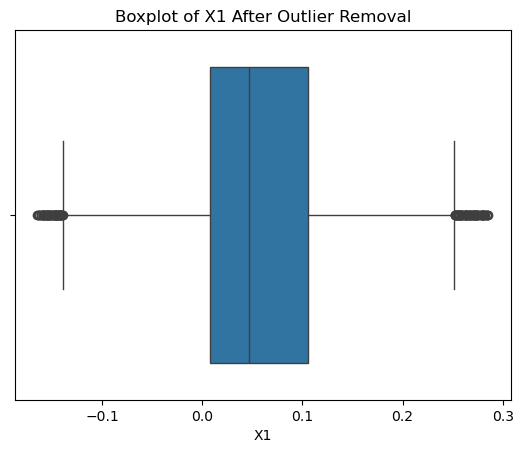

<Axes: xlabel='X1', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X1 After Outlier Removal')

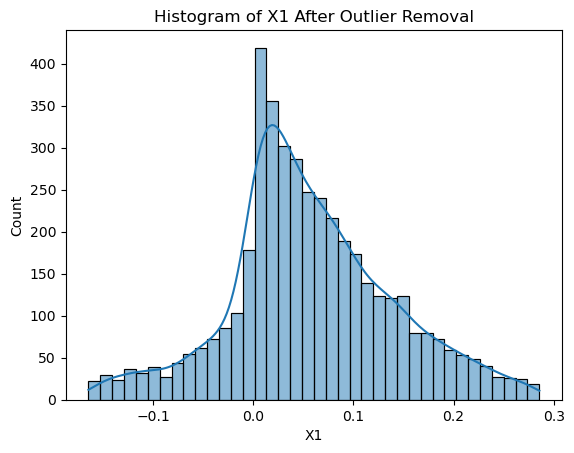

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X2'>

Text(0.5, 1.0, 'Boxplot of X2 After Outlier Removal')

<Axes: xlabel='X2', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X2 After Outlier Removal')

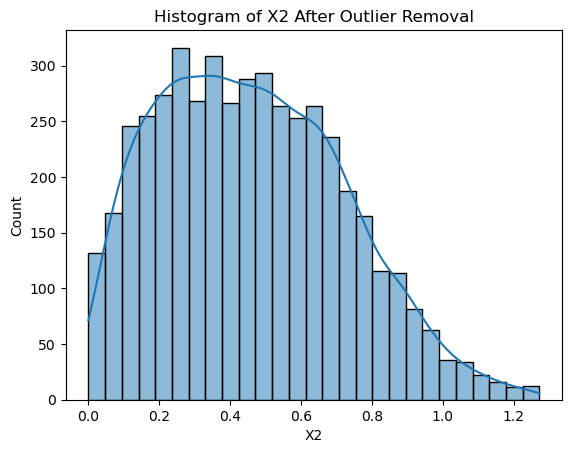

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X3'>

Text(0.5, 1.0, 'Boxplot of X3 After Outlier Removal')

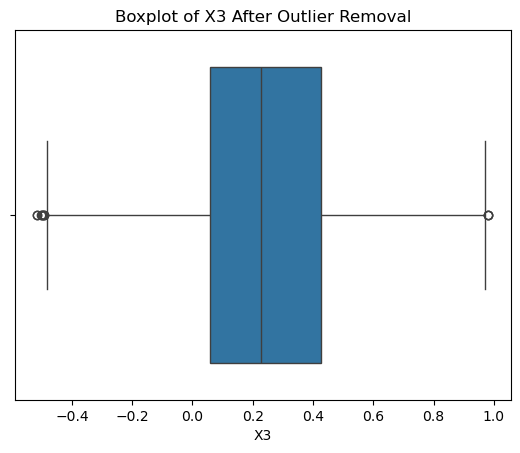

<Axes: xlabel='X3', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X3 After Outlier Removal')

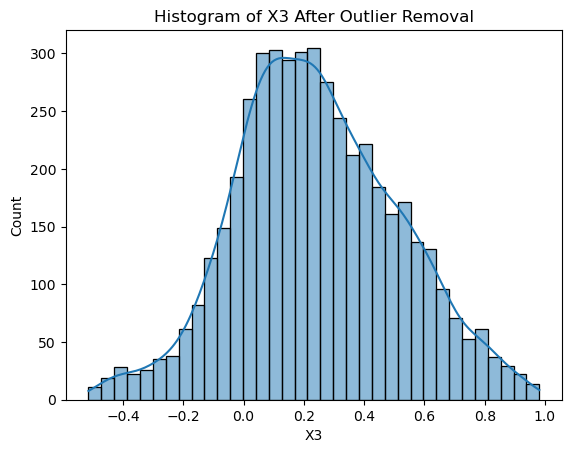

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X4'>

Text(0.5, 1.0, 'Boxplot of X4 After Outlier Removal')

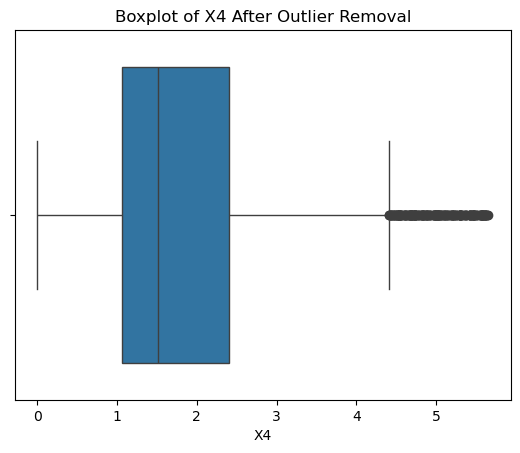

<Axes: xlabel='X4', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X4 After Outlier Removal')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X5'>

Text(0.5, 1.0, 'Boxplot of X5 After Outlier Removal')

<Axes: xlabel='X5', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X5 After Outlier Removal')

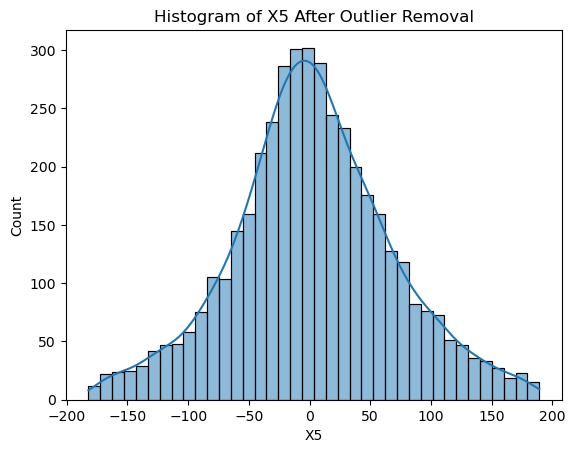

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X6'>

Text(0.5, 1.0, 'Boxplot of X6 After Outlier Removal')

<Axes: xlabel='X6', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X6 After Outlier Removal')

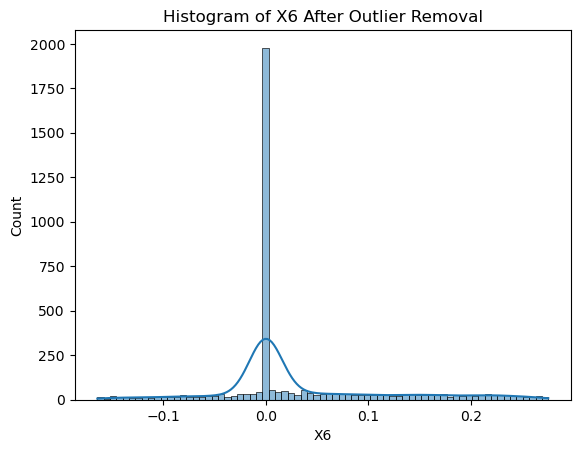

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X7'>

Text(0.5, 1.0, 'Boxplot of X7 After Outlier Removal')

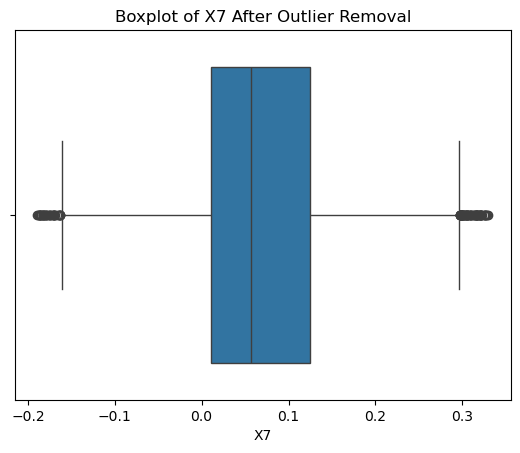

<Axes: xlabel='X7', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X7 After Outlier Removal')

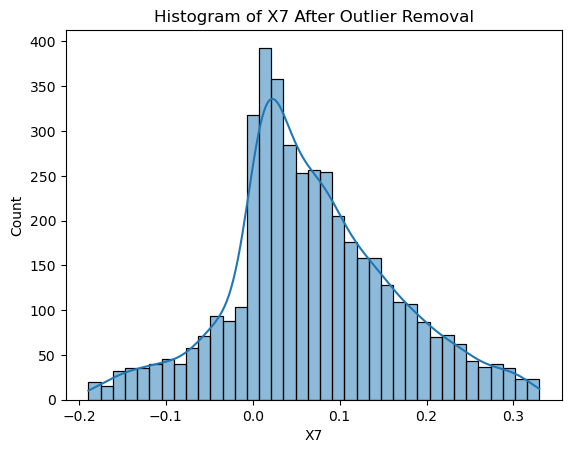

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X8'>

Text(0.5, 1.0, 'Boxplot of X8 After Outlier Removal')

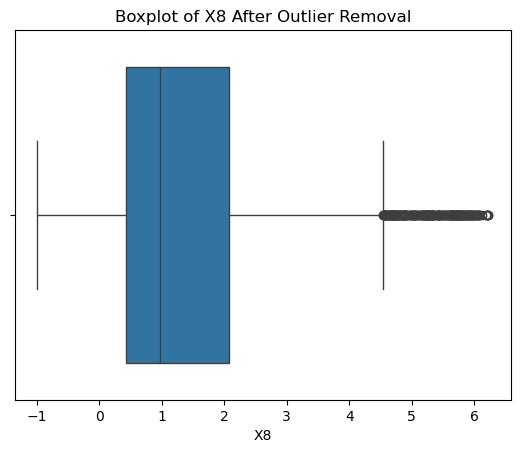

<Axes: xlabel='X8', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X8 After Outlier Removal')

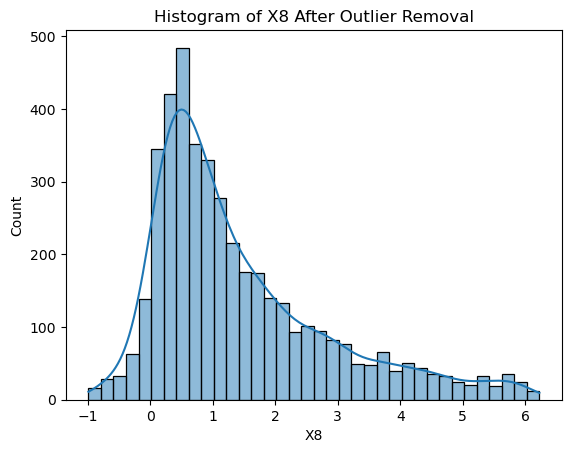

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X9'>

Text(0.5, 1.0, 'Boxplot of X9 After Outlier Removal')

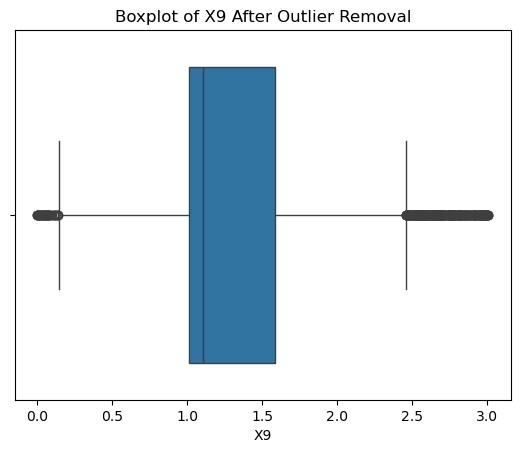

<Axes: xlabel='X9', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X9 After Outlier Removal')

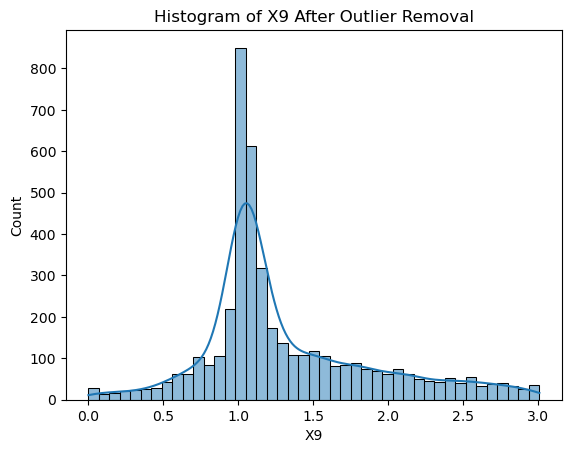

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X10'>

Text(0.5, 1.0, 'Boxplot of X10 After Outlier Removal')

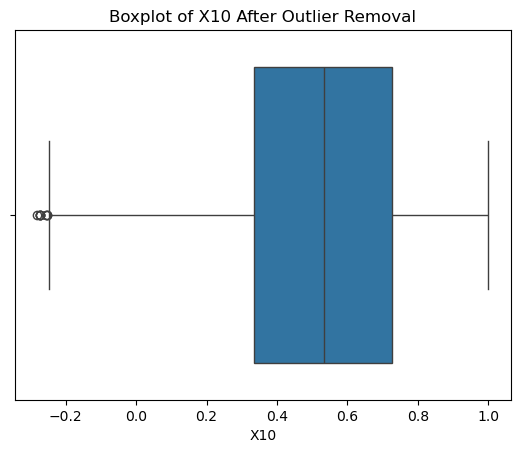

<Axes: xlabel='X10', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X10 After Outlier Removal')

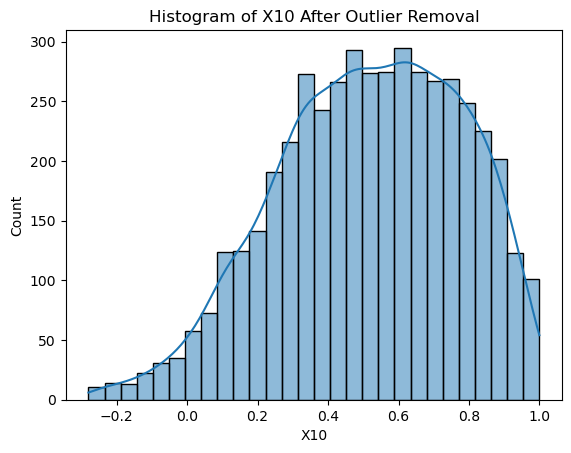

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X11'>

Text(0.5, 1.0, 'Boxplot of X11 After Outlier Removal')

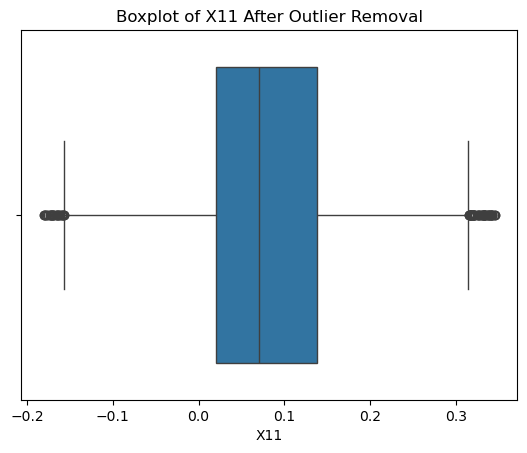

<Axes: xlabel='X11', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X11 After Outlier Removal')

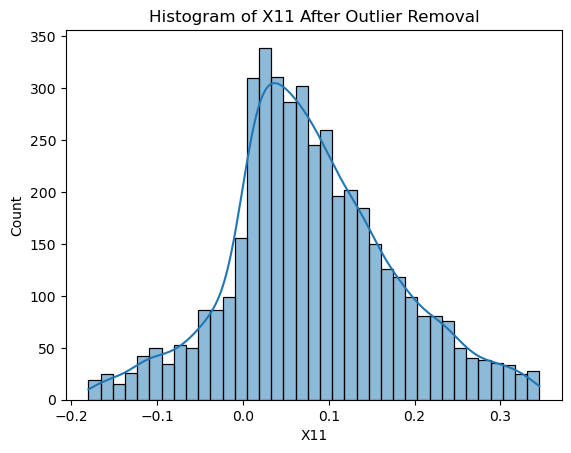

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X12'>

Text(0.5, 1.0, 'Boxplot of X12 After Outlier Removal')

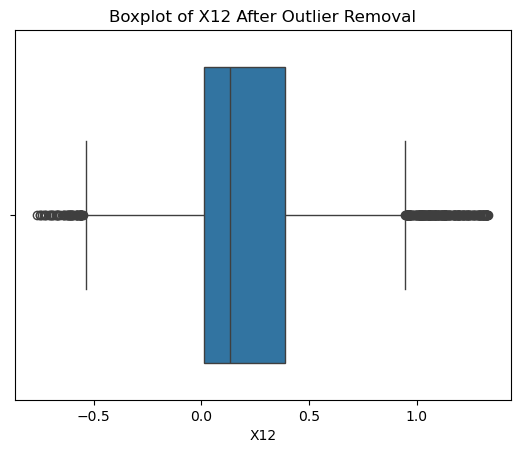

<Axes: xlabel='X12', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X12 After Outlier Removal')

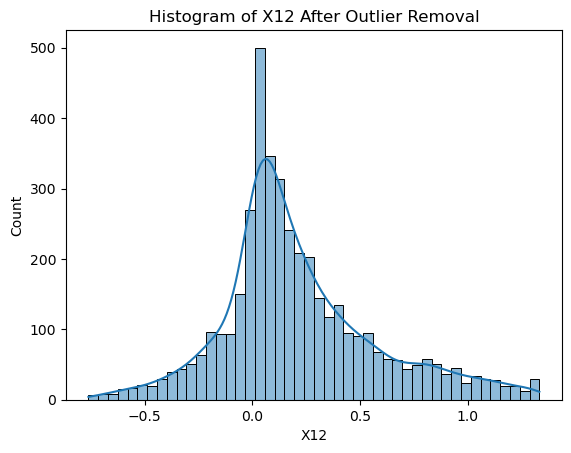

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X13'>

Text(0.5, 1.0, 'Boxplot of X13 After Outlier Removal')

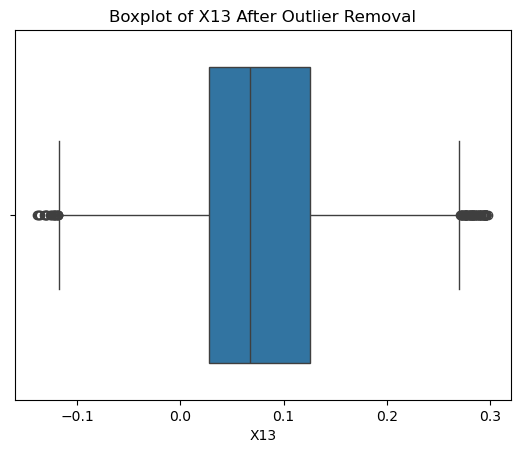

<Axes: xlabel='X13', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X13 After Outlier Removal')

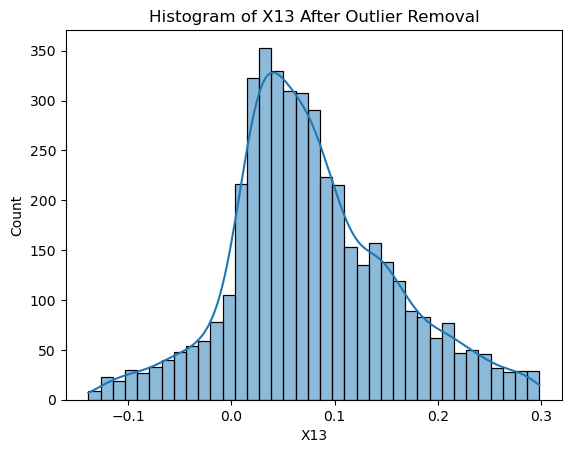

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X14'>

Text(0.5, 1.0, 'Boxplot of X14 After Outlier Removal')

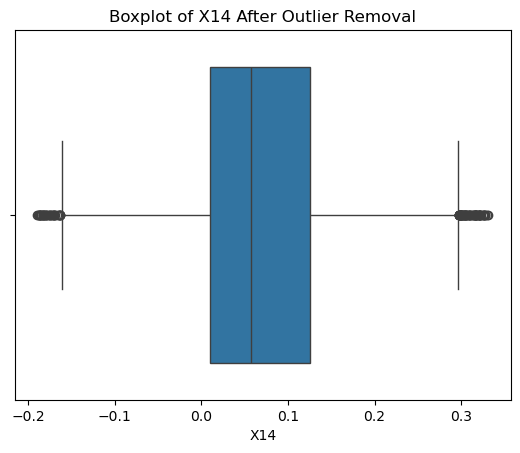

<Axes: xlabel='X14', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X14 After Outlier Removal')

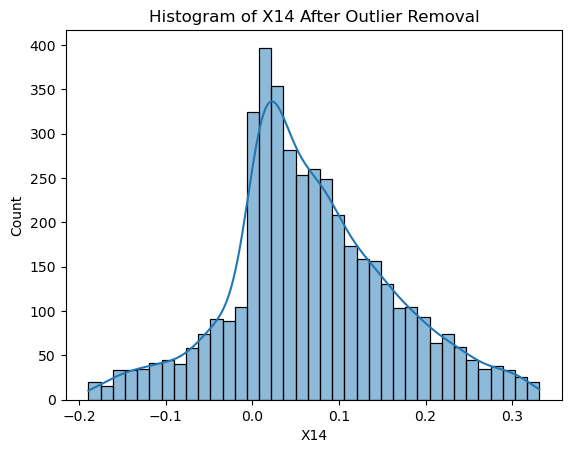

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X15'>

Text(0.5, 1.0, 'Boxplot of X15 After Outlier Removal')

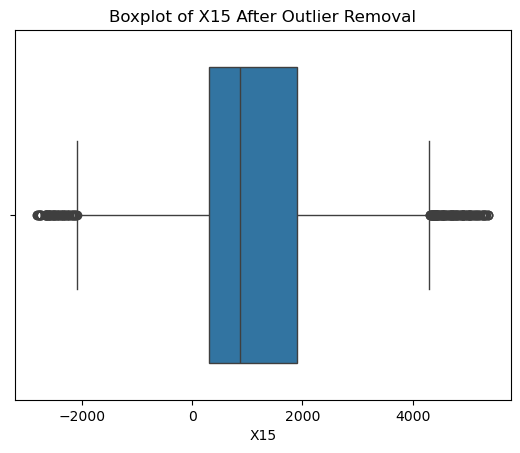

<Axes: xlabel='X15', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X15 After Outlier Removal')

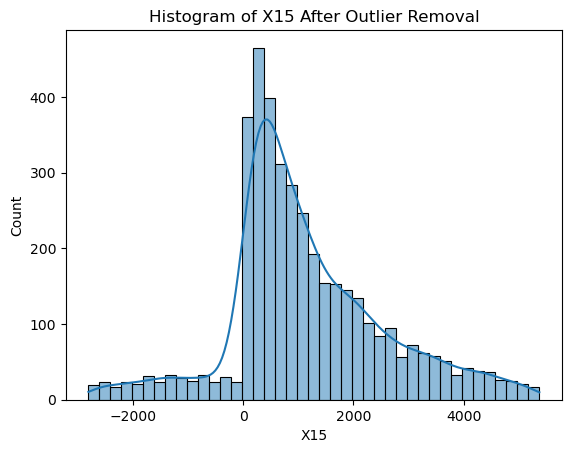

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X16'>

Text(0.5, 1.0, 'Boxplot of X16 After Outlier Removal')

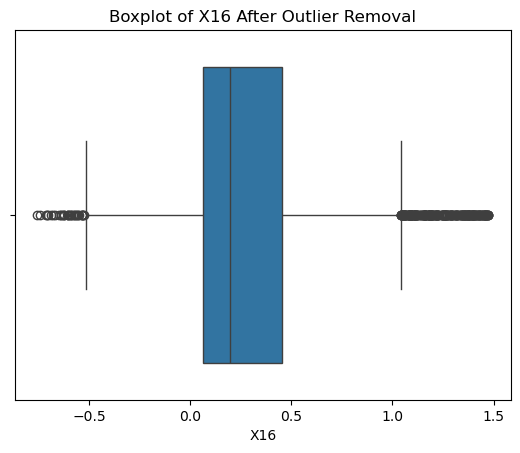

<Axes: xlabel='X16', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X16 After Outlier Removal')

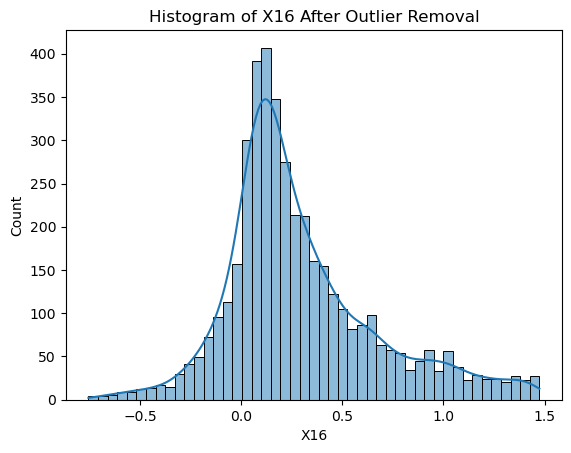

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X17'>

Text(0.5, 1.0, 'Boxplot of X17 After Outlier Removal')

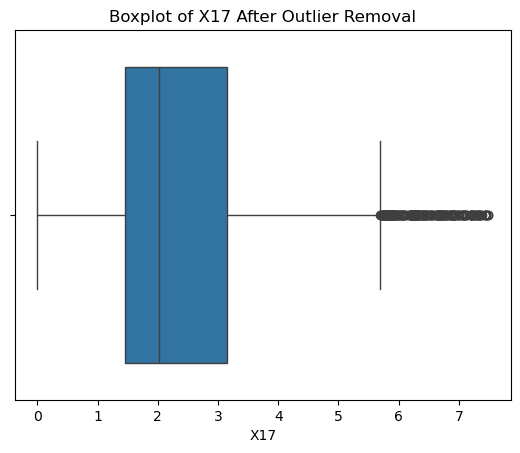

<Axes: xlabel='X17', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X17 After Outlier Removal')

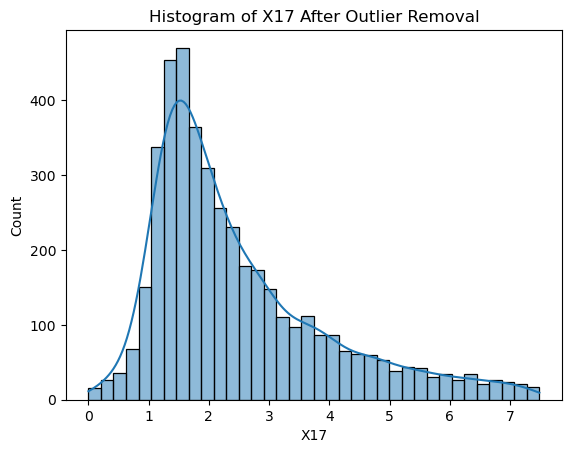

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X18'>

Text(0.5, 1.0, 'Boxplot of X18 After Outlier Removal')

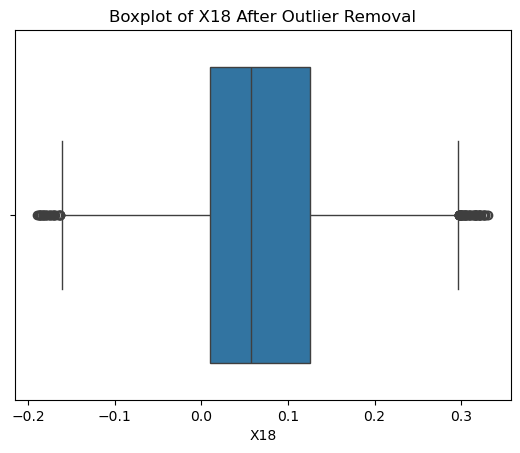

<Axes: xlabel='X18', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X18 After Outlier Removal')

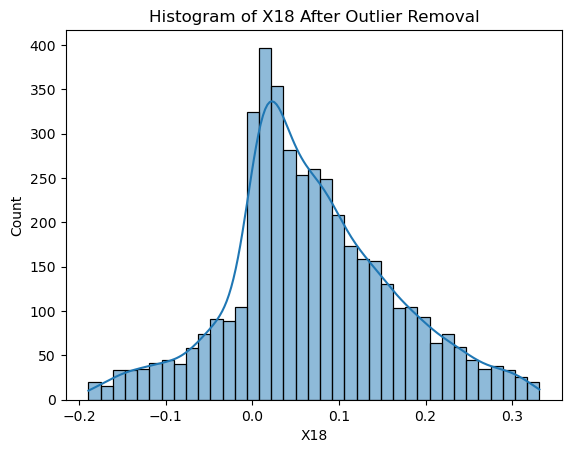

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X19'>

Text(0.5, 1.0, 'Boxplot of X19 After Outlier Removal')

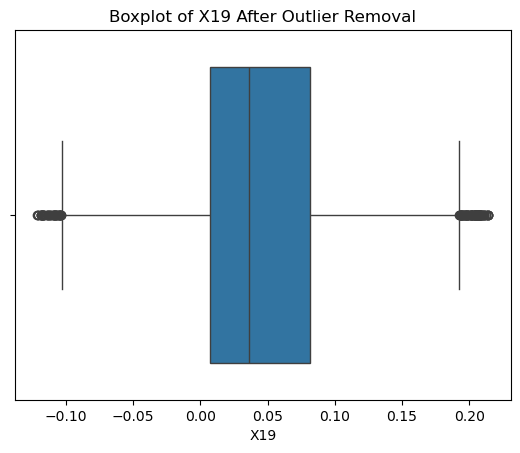

<Axes: xlabel='X19', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X19 After Outlier Removal')

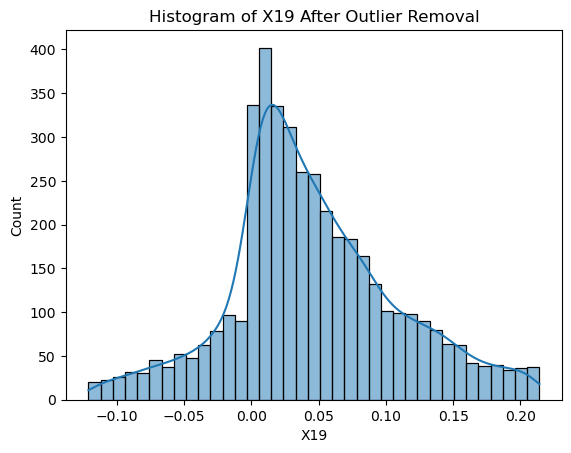

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X20'>

Text(0.5, 1.0, 'Boxplot of X20 After Outlier Removal')

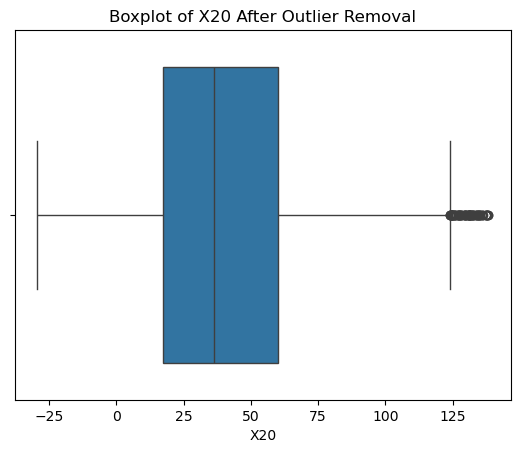

<Axes: xlabel='X20', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X20 After Outlier Removal')

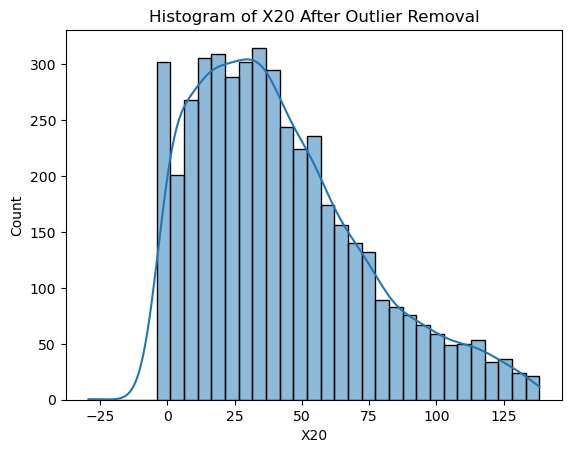

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X21'>

Text(0.5, 1.0, 'Boxplot of X21 After Outlier Removal')

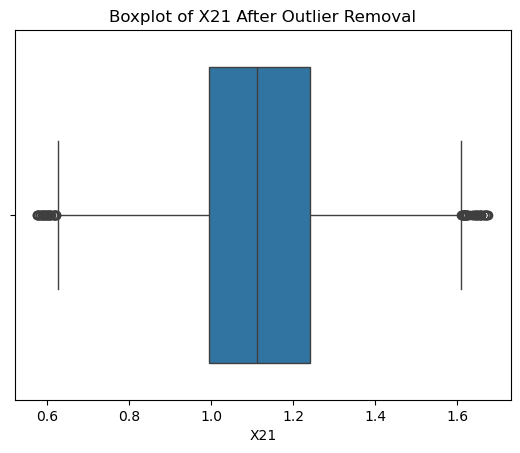

<Axes: xlabel='X21', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X21 After Outlier Removal')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X22'>

Text(0.5, 1.0, 'Boxplot of X22 After Outlier Removal')

<Axes: xlabel='X22', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X22 After Outlier Removal')

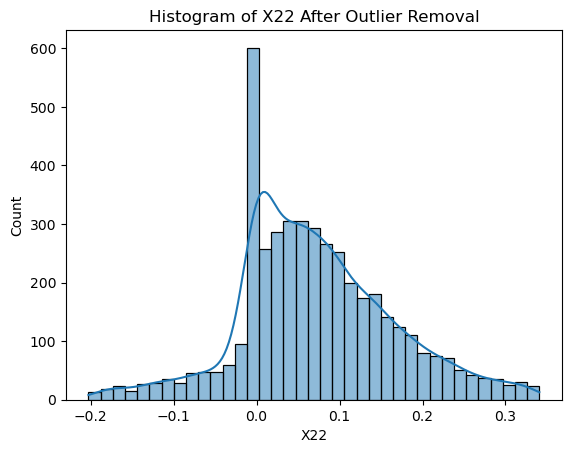

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X23'>

Text(0.5, 1.0, 'Boxplot of X23 After Outlier Removal')

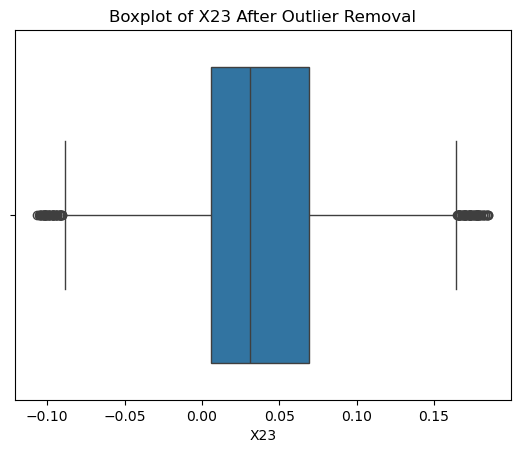

<Axes: xlabel='X23', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X23 After Outlier Removal')

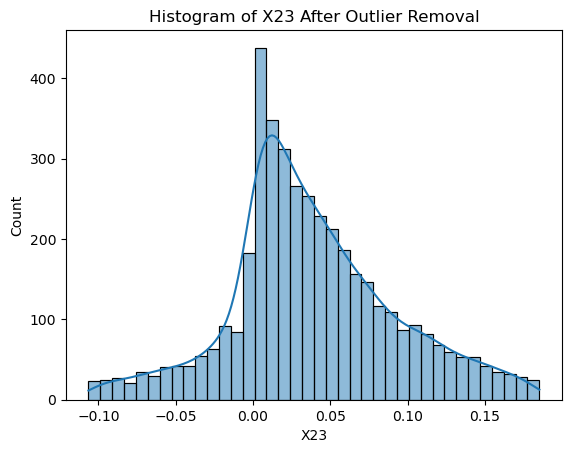

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X24'>

Text(0.5, 1.0, 'Boxplot of X24 After Outlier Removal')

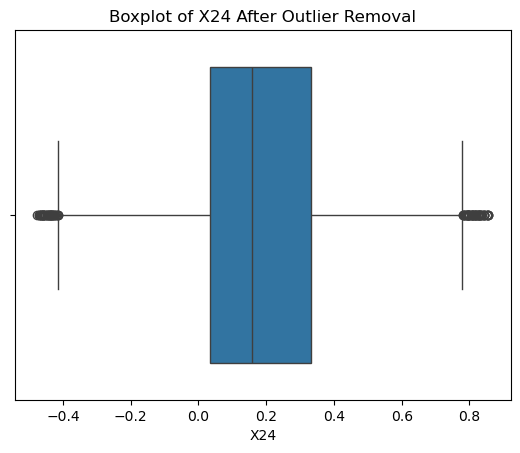

<Axes: xlabel='X24', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X24 After Outlier Removal')

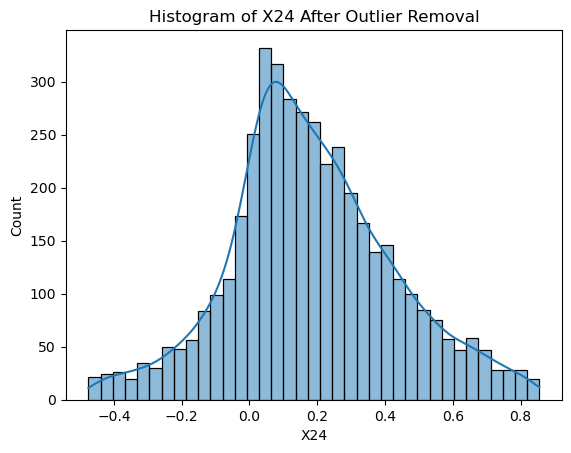

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X25'>

Text(0.5, 1.0, 'Boxplot of X25 After Outlier Removal')

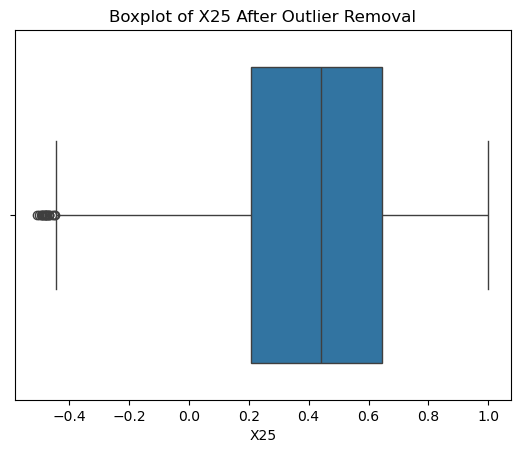

<Axes: xlabel='X25', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X25 After Outlier Removal')

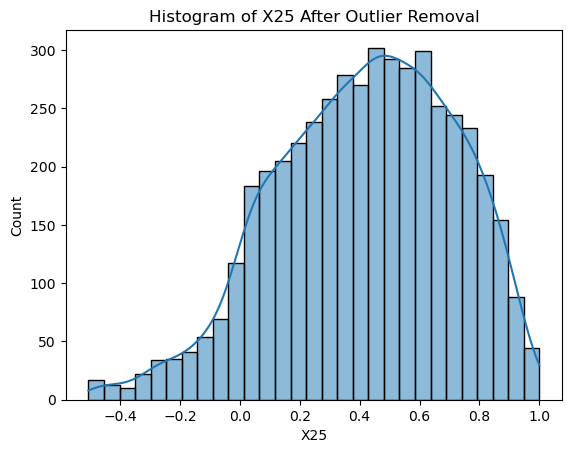

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X26'>

Text(0.5, 1.0, 'Boxplot of X26 After Outlier Removal')

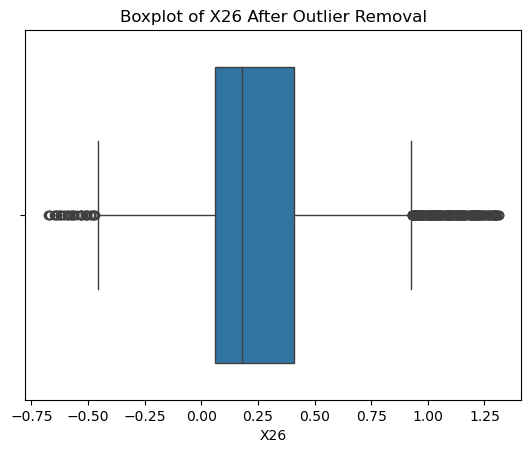

<Axes: xlabel='X26', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X26 After Outlier Removal')

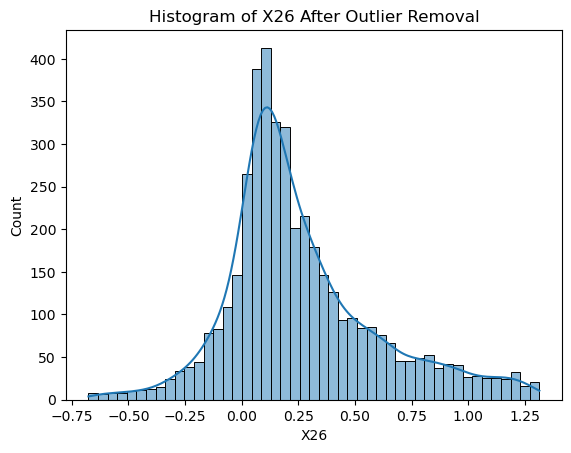

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X27'>

Text(0.5, 1.0, 'Boxplot of X27 After Outlier Removal')

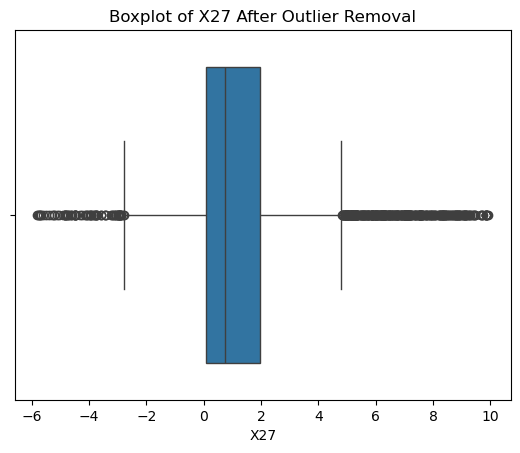

<Axes: xlabel='X27', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X27 After Outlier Removal')

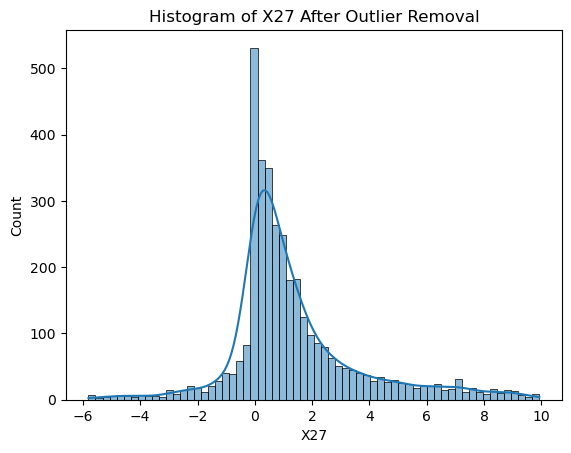

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X28'>

Text(0.5, 1.0, 'Boxplot of X28 After Outlier Removal')

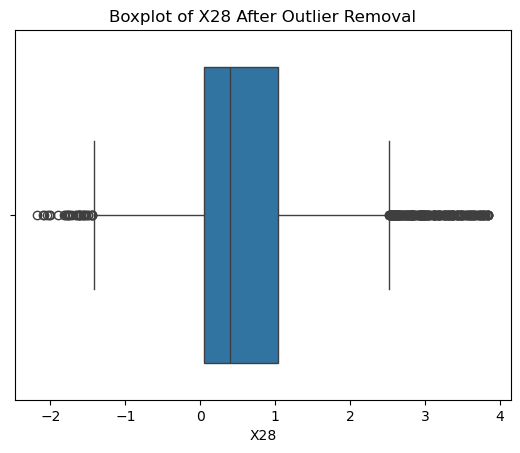

<Axes: xlabel='X28', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X28 After Outlier Removal')

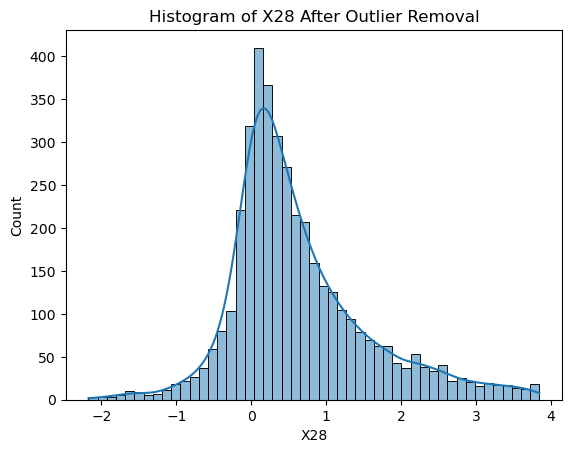

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X29'>

Text(0.5, 1.0, 'Boxplot of X29 After Outlier Removal')

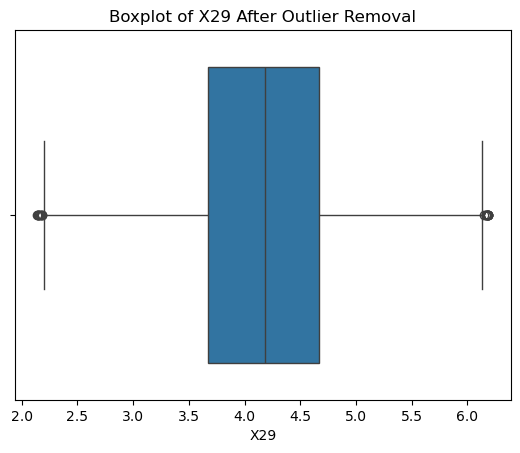

<Axes: xlabel='X29', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X29 After Outlier Removal')

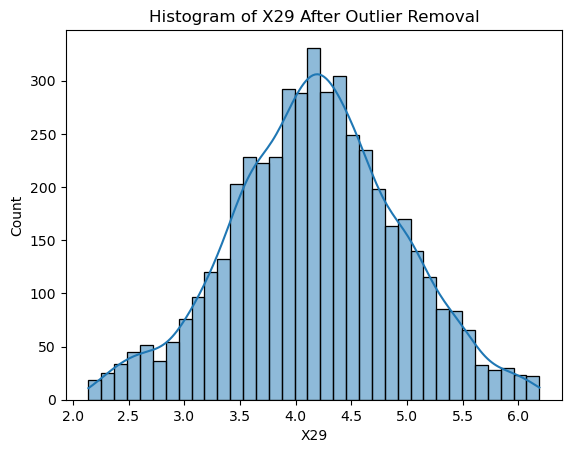

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X30'>

Text(0.5, 1.0, 'Boxplot of X30 After Outlier Removal')

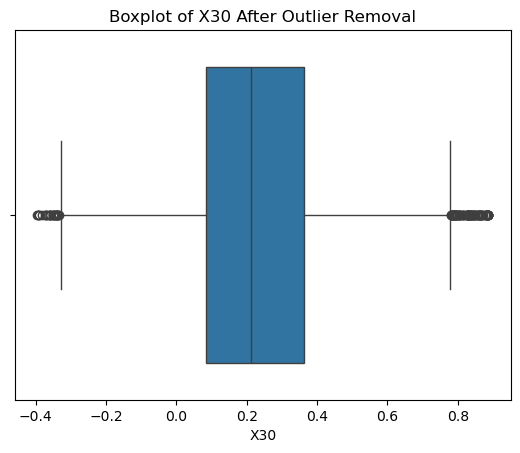

<Axes: xlabel='X30', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X30 After Outlier Removal')

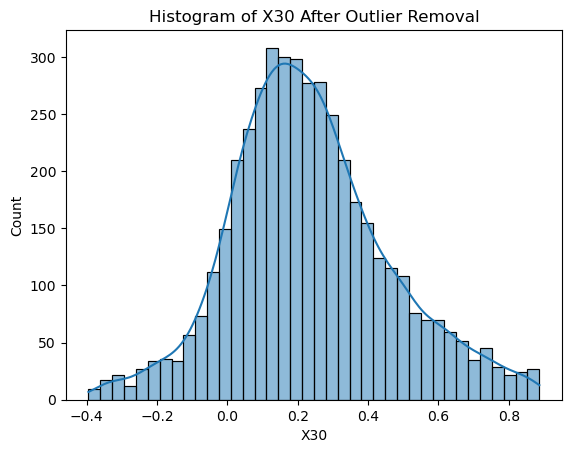

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X31'>

Text(0.5, 1.0, 'Boxplot of X31 After Outlier Removal')

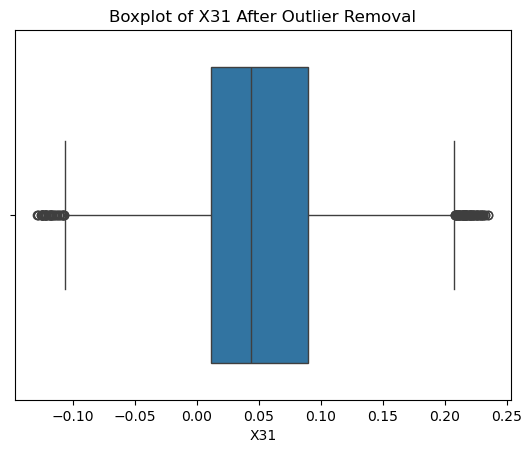

<Axes: xlabel='X31', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X31 After Outlier Removal')

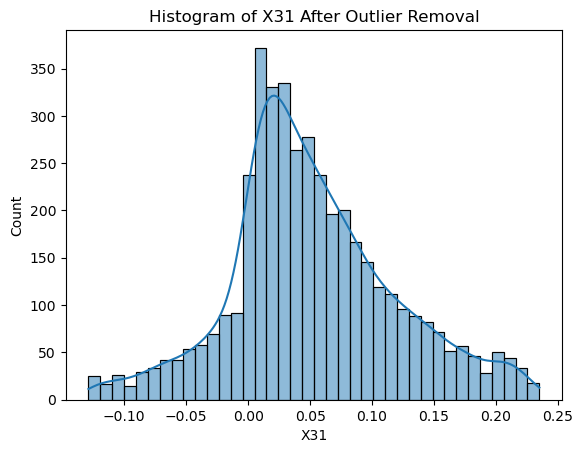

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X32'>

Text(0.5, 1.0, 'Boxplot of X32 After Outlier Removal')

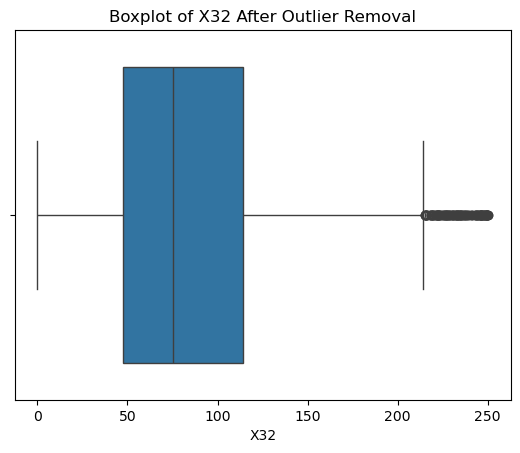

<Axes: xlabel='X32', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X32 After Outlier Removal')

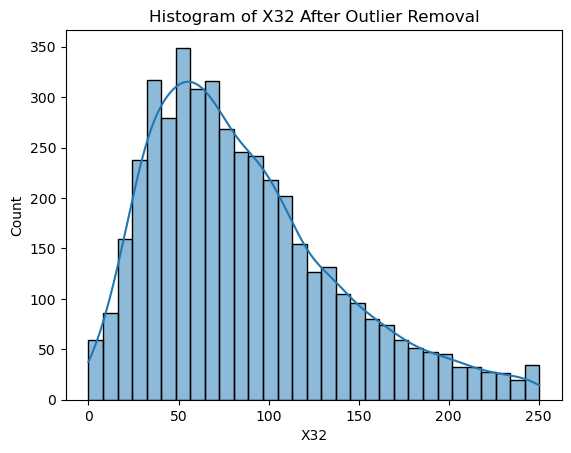

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X33'>

Text(0.5, 1.0, 'Boxplot of X33 After Outlier Removal')

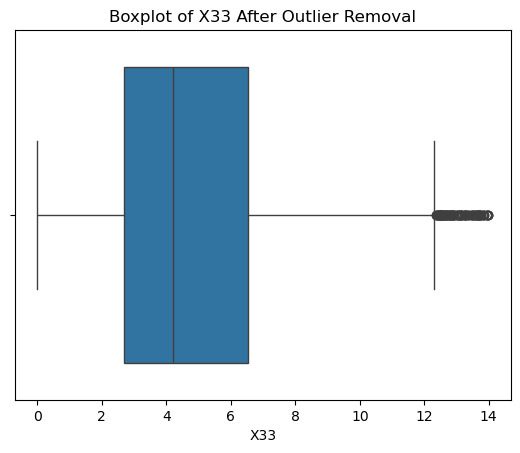

<Axes: xlabel='X33', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X33 After Outlier Removal')

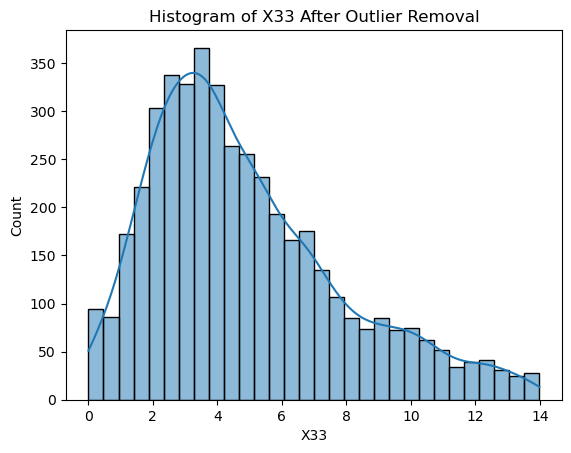

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X34'>

Text(0.5, 1.0, 'Boxplot of X34 After Outlier Removal')

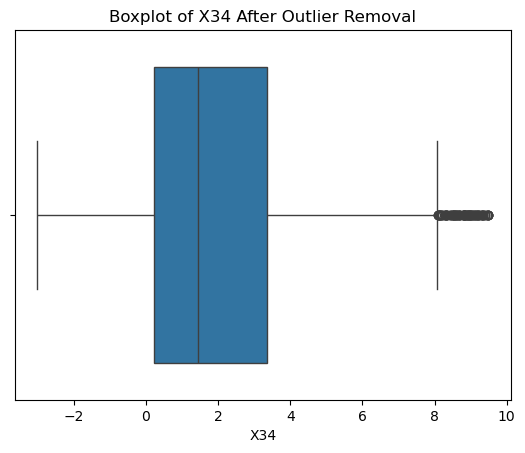

<Axes: xlabel='X34', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X34 After Outlier Removal')

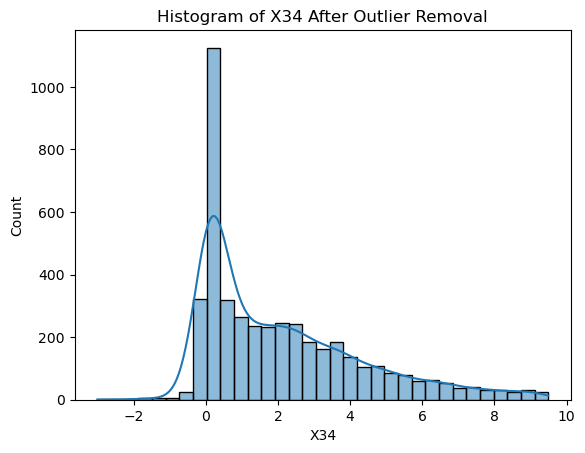

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X35'>

Text(0.5, 1.0, 'Boxplot of X35 After Outlier Removal')

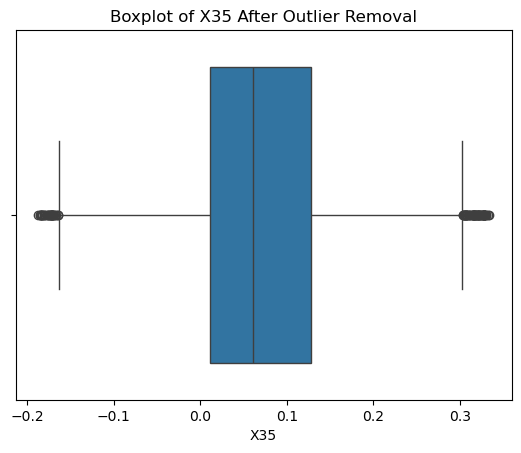

<Axes: xlabel='X35', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X35 After Outlier Removal')

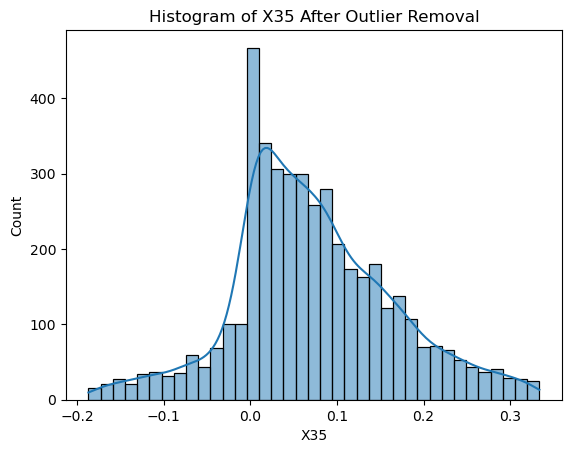

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X36'>

Text(0.5, 1.0, 'Boxplot of X36 After Outlier Removal')

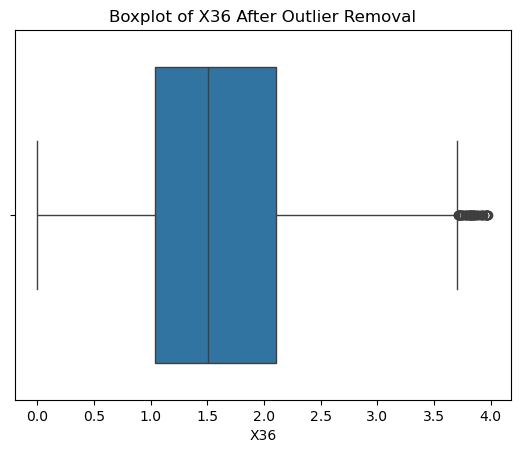

<Axes: xlabel='X36', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X36 After Outlier Removal')

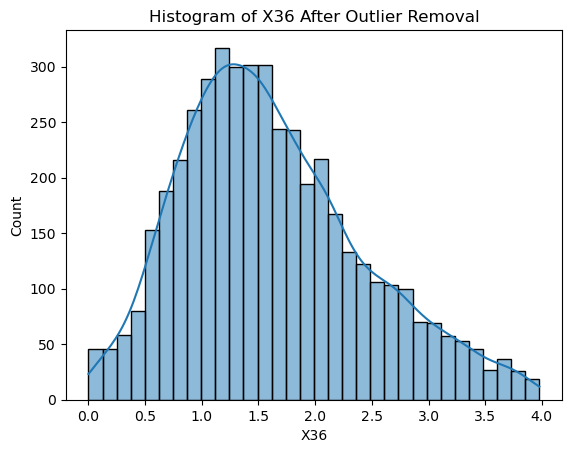

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X37'>

Text(0.5, 1.0, 'Boxplot of X37 After Outlier Removal')

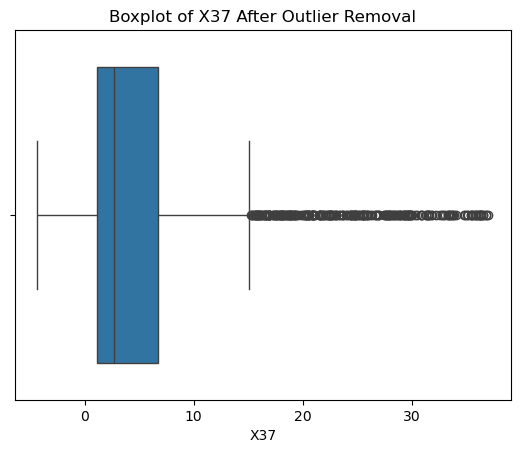

<Axes: xlabel='X37', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X37 After Outlier Removal')

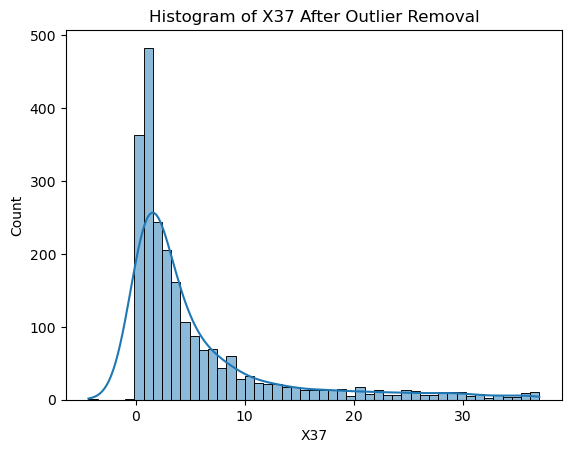

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X38'>

Text(0.5, 1.0, 'Boxplot of X38 After Outlier Removal')

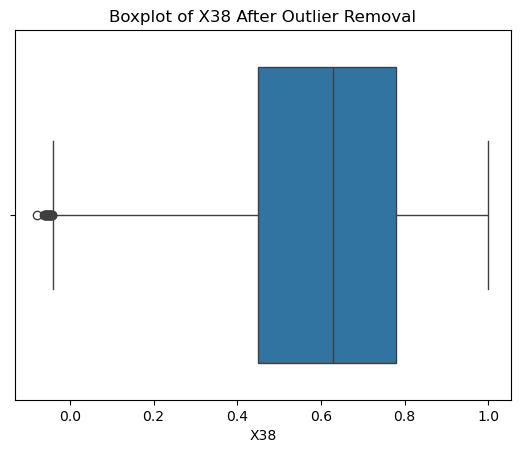

<Axes: xlabel='X38', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X38 After Outlier Removal')

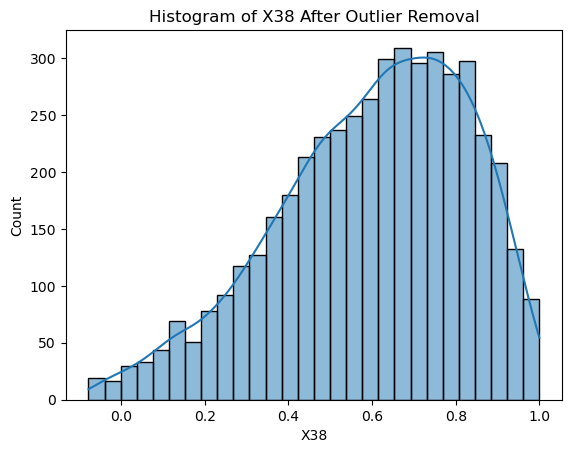

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X39'>

Text(0.5, 1.0, 'Boxplot of X39 After Outlier Removal')

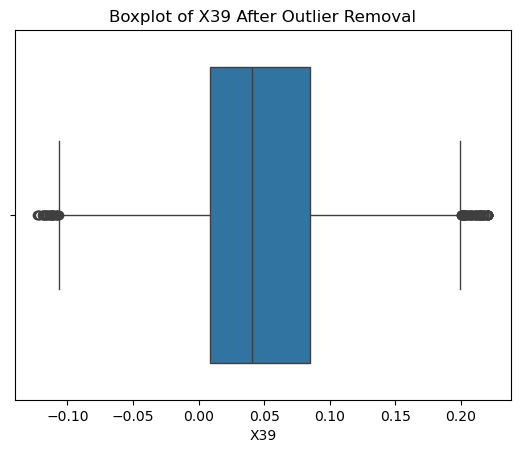

<Axes: xlabel='X39', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X39 After Outlier Removal')

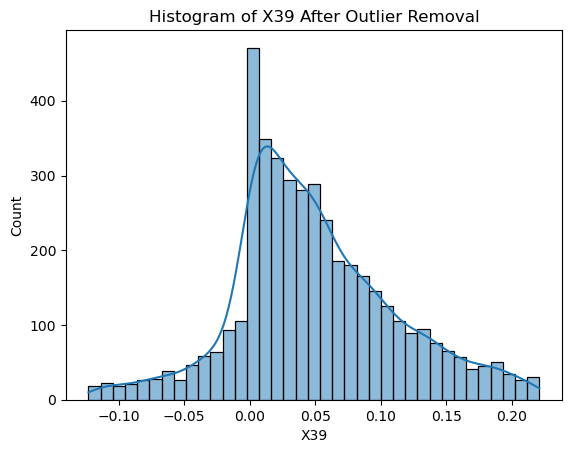

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X40'>

Text(0.5, 1.0, 'Boxplot of X40 After Outlier Removal')

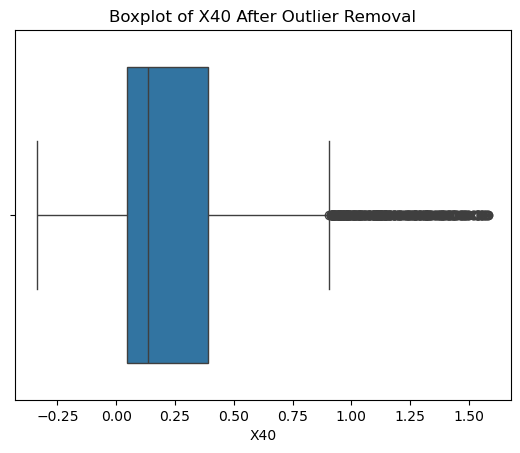

<Axes: xlabel='X40', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X40 After Outlier Removal')

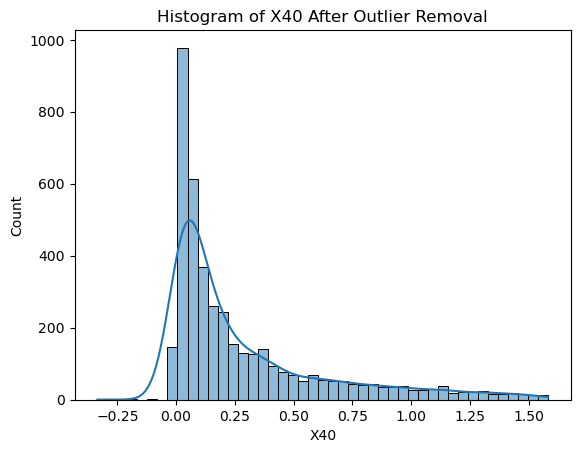

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X41'>

Text(0.5, 1.0, 'Boxplot of X41 After Outlier Removal')

<Axes: xlabel='X41', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X41 After Outlier Removal')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X42'>

Text(0.5, 1.0, 'Boxplot of X42 After Outlier Removal')

<Axes: xlabel='X42', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X42 After Outlier Removal')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X43'>

Text(0.5, 1.0, 'Boxplot of X43 After Outlier Removal')

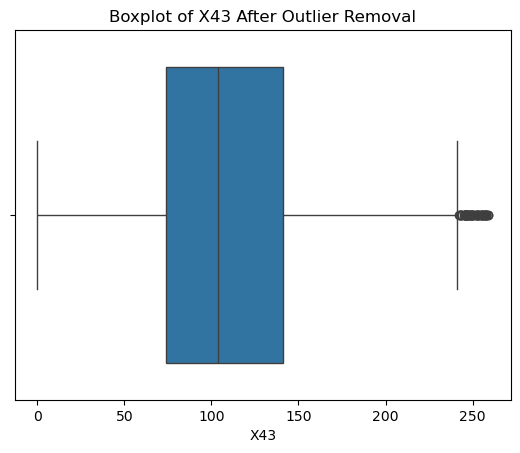

<Axes: xlabel='X43', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X43 After Outlier Removal')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X44'>

Text(0.5, 1.0, 'Boxplot of X44 After Outlier Removal')

<Axes: xlabel='X44', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X44 After Outlier Removal')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X45'>

Text(0.5, 1.0, 'Boxplot of X45 After Outlier Removal')

<Axes: xlabel='X45', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X45 After Outlier Removal')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X46'>

Text(0.5, 1.0, 'Boxplot of X46 After Outlier Removal')

<Axes: xlabel='X46', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X46 After Outlier Removal')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X47'>

Text(0.5, 1.0, 'Boxplot of X47 After Outlier Removal')

<Axes: xlabel='X47', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X47 After Outlier Removal')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X48'>

Text(0.5, 1.0, 'Boxplot of X48 After Outlier Removal')

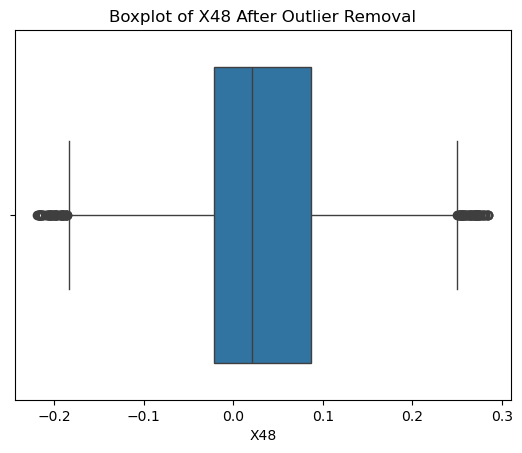

<Axes: xlabel='X48', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X48 After Outlier Removal')

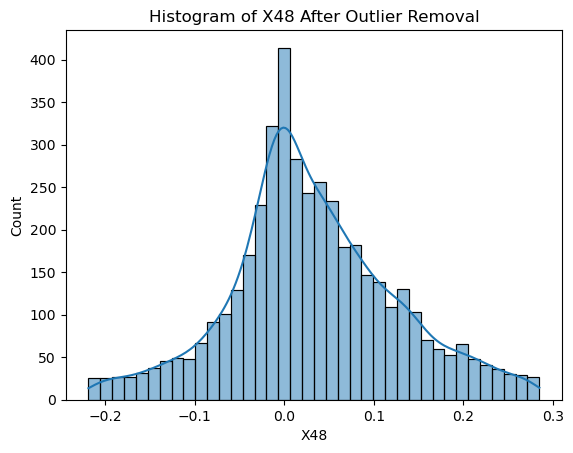

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X49'>

Text(0.5, 1.0, 'Boxplot of X49 After Outlier Removal')

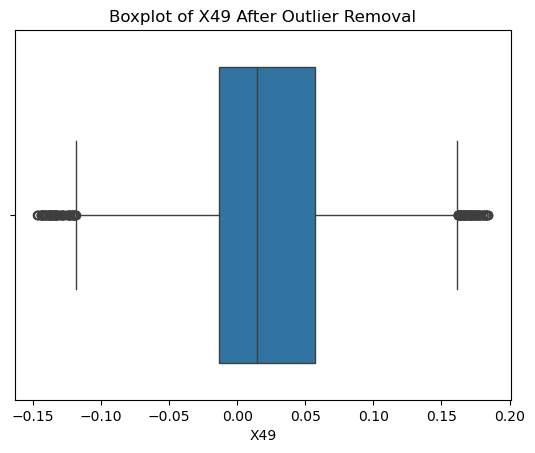

<Axes: xlabel='X49', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X49 After Outlier Removal')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X50'>

Text(0.5, 1.0, 'Boxplot of X50 After Outlier Removal')

<Axes: xlabel='X50', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X50 After Outlier Removal')

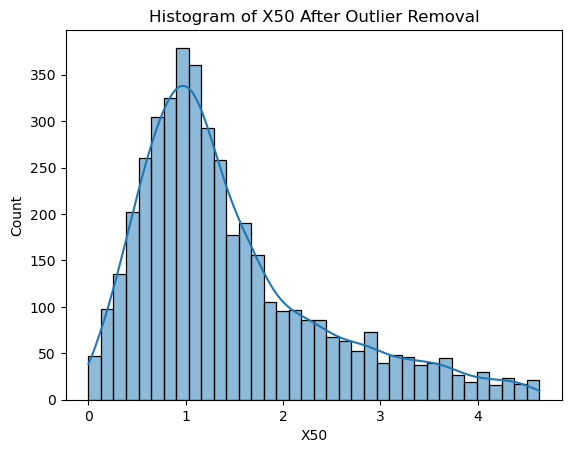

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X51'>

Text(0.5, 1.0, 'Boxplot of X51 After Outlier Removal')

<Axes: xlabel='X51', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X51 After Outlier Removal')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X52'>

Text(0.5, 1.0, 'Boxplot of X52 After Outlier Removal')

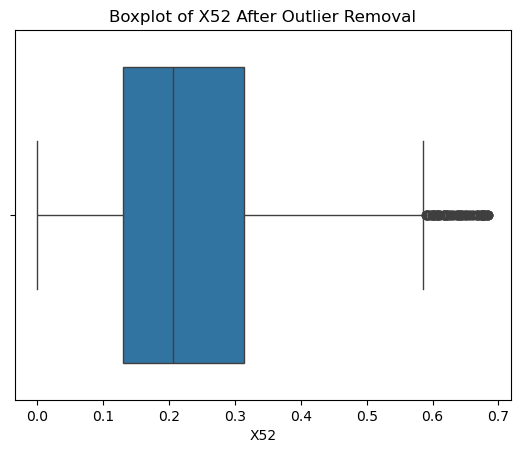

<Axes: xlabel='X52', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X52 After Outlier Removal')

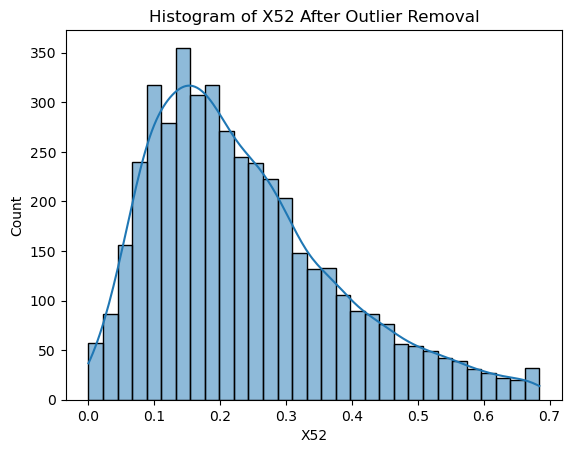

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X53'>

Text(0.5, 1.0, 'Boxplot of X53 After Outlier Removal')

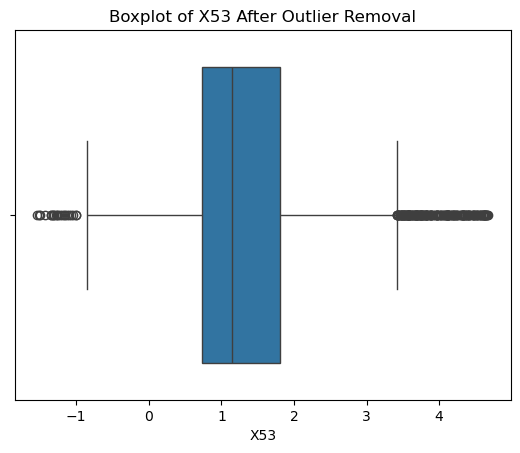

<Axes: xlabel='X53', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X53 After Outlier Removal')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X54'>

Text(0.5, 1.0, 'Boxplot of X54 After Outlier Removal')

<Axes: xlabel='X54', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X54 After Outlier Removal')

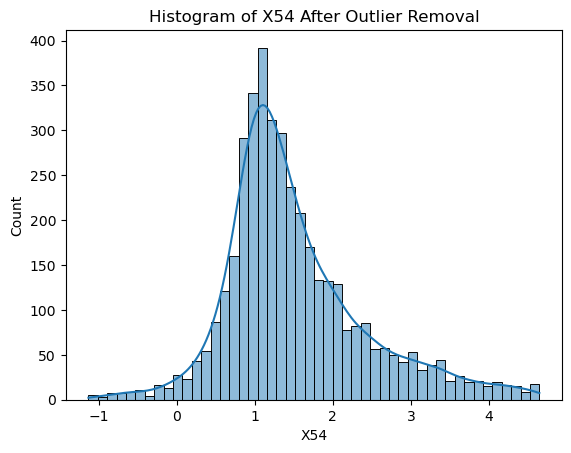

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X55'>

Text(0.5, 1.0, 'Boxplot of X55 After Outlier Removal')

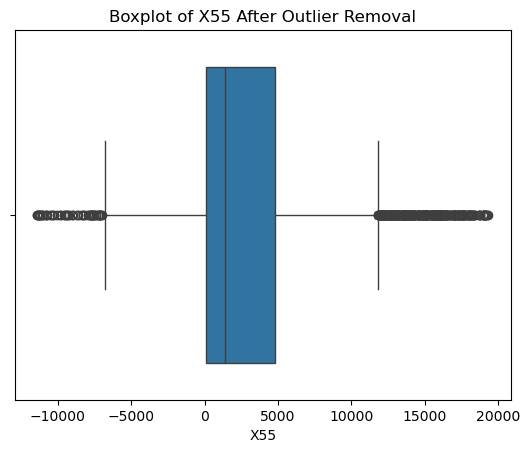

<Axes: xlabel='X55', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X55 After Outlier Removal')

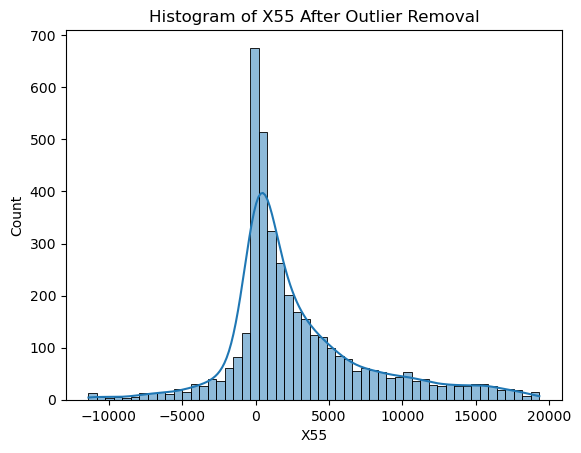

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X56'>

Text(0.5, 1.0, 'Boxplot of X56 After Outlier Removal')

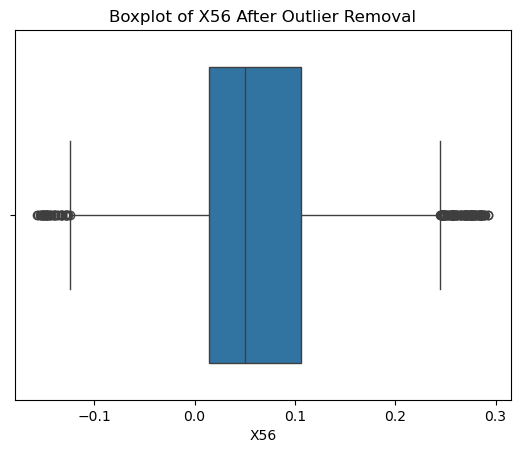

<Axes: xlabel='X56', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X56 After Outlier Removal')

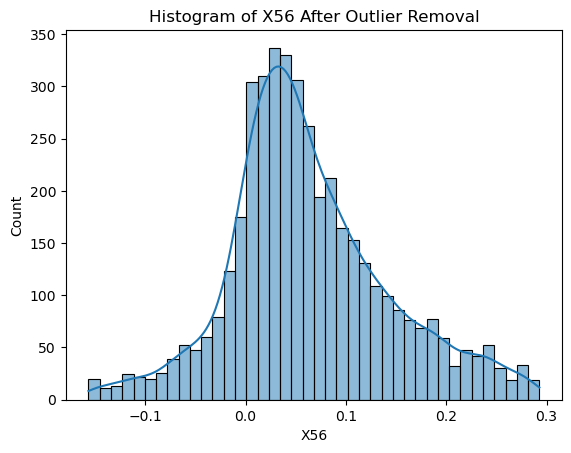

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X57'>

Text(0.5, 1.0, 'Boxplot of X57 After Outlier Removal')

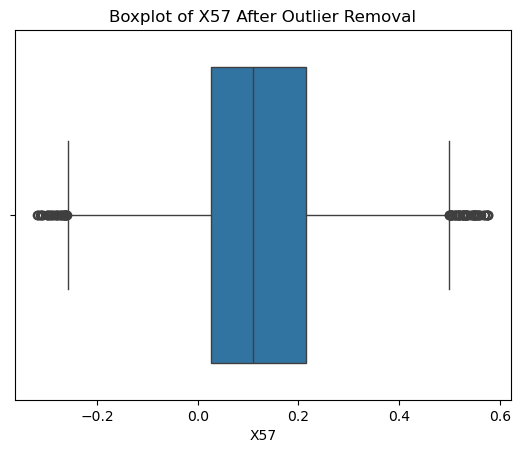

<Axes: xlabel='X57', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X57 After Outlier Removal')

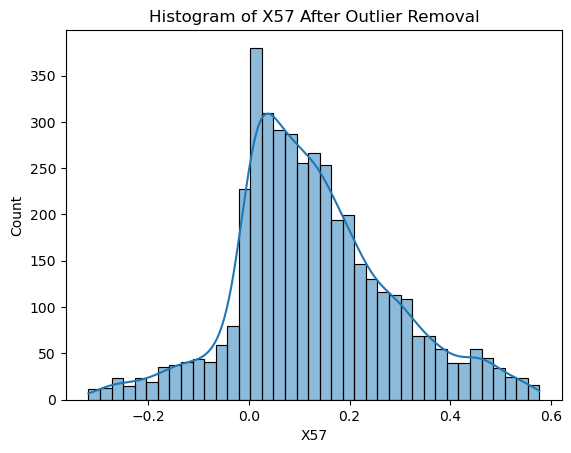

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X58'>

Text(0.5, 1.0, 'Boxplot of X58 After Outlier Removal')

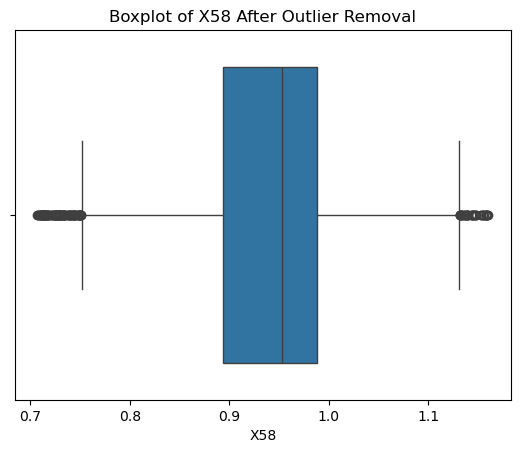

<Axes: xlabel='X58', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X58 After Outlier Removal')

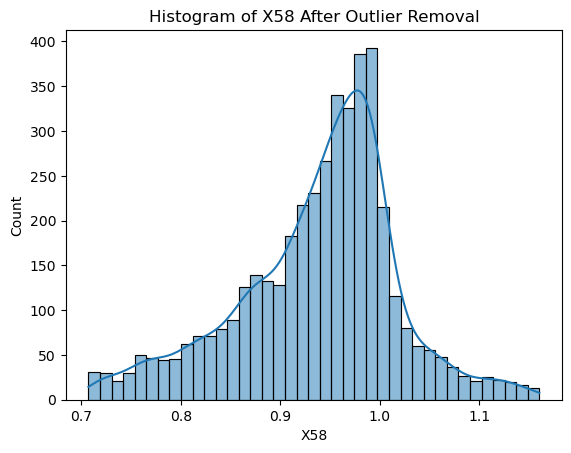

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X59'>

Text(0.5, 1.0, 'Boxplot of X59 After Outlier Removal')

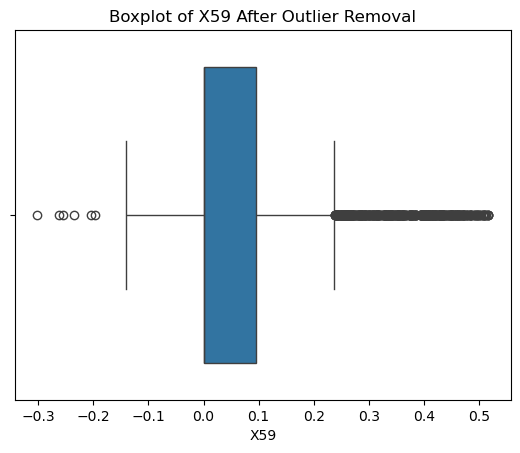

<Axes: xlabel='X59', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X59 After Outlier Removal')

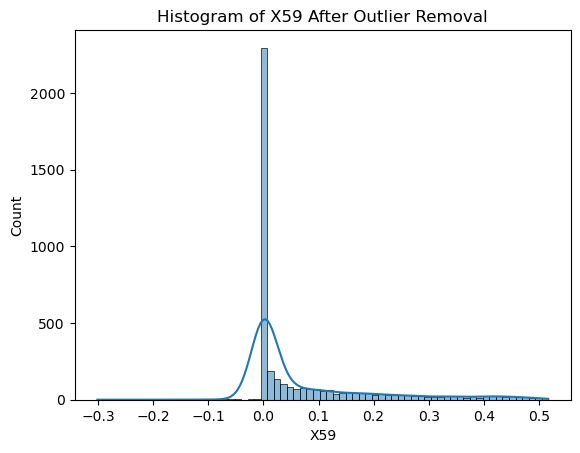

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X60'>

Text(0.5, 1.0, 'Boxplot of X60 After Outlier Removal')

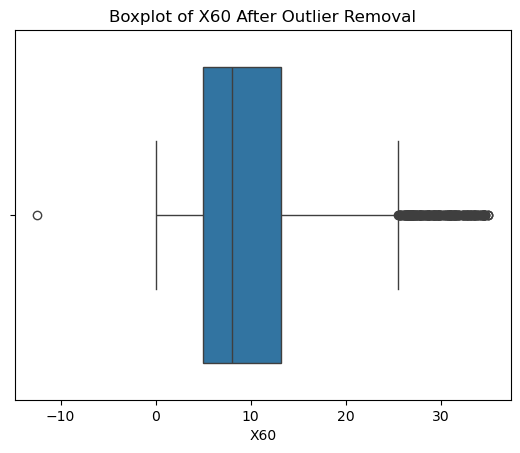

<Axes: xlabel='X60', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X60 After Outlier Removal')

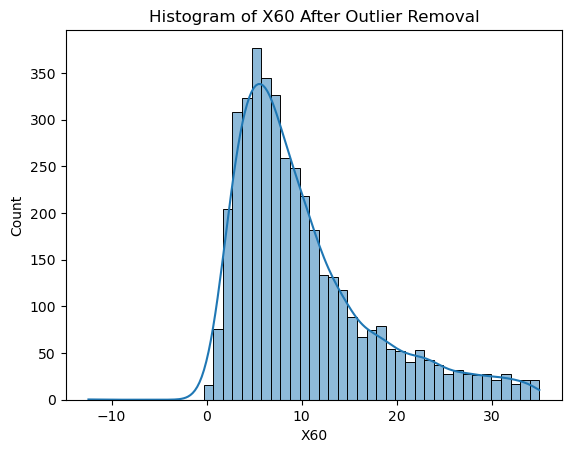

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X61'>

Text(0.5, 1.0, 'Boxplot of X61 After Outlier Removal')

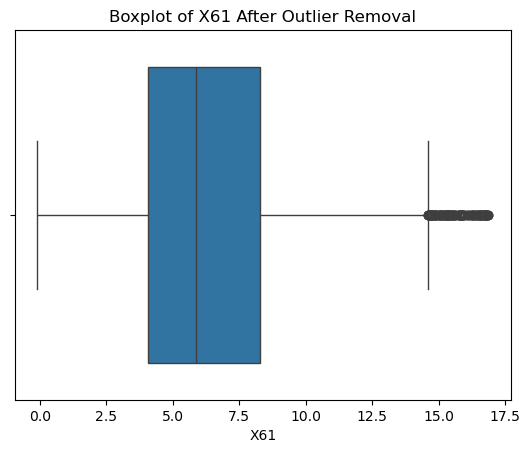

<Axes: xlabel='X61', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X61 After Outlier Removal')

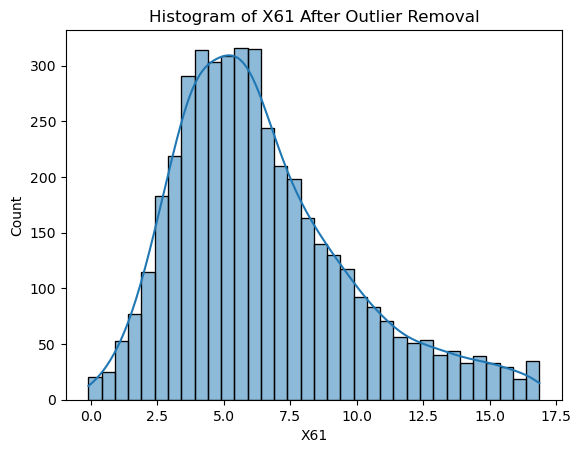

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X62'>

Text(0.5, 1.0, 'Boxplot of X62 After Outlier Removal')

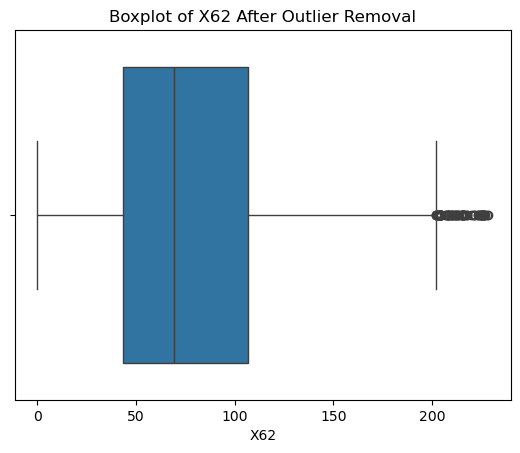

<Axes: xlabel='X62', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X62 After Outlier Removal')

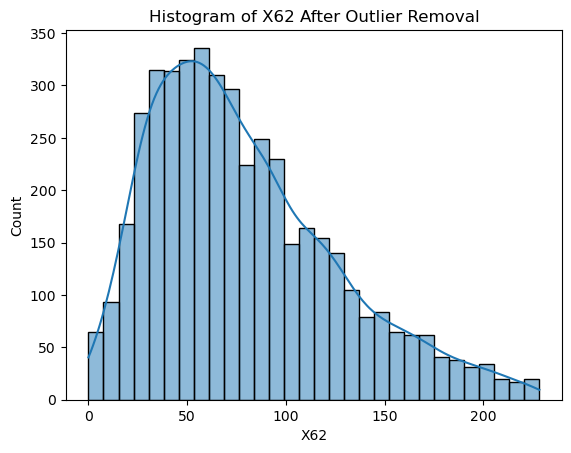

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X63'>

Text(0.5, 1.0, 'Boxplot of X63 After Outlier Removal')

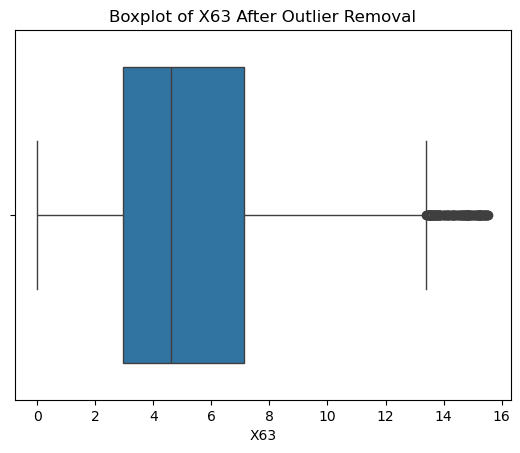

<Axes: xlabel='X63', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X63 After Outlier Removal')

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='X64'>

Text(0.5, 1.0, 'Boxplot of X64 After Outlier Removal')

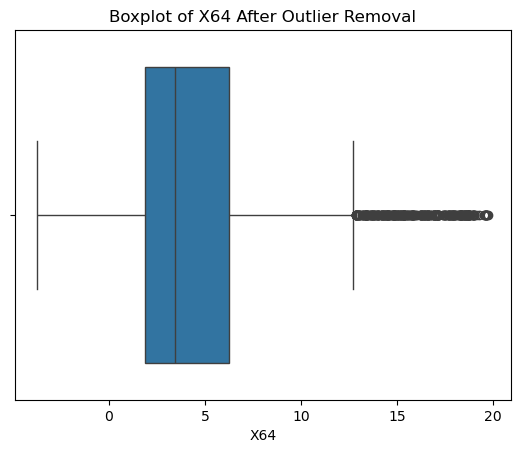

<Axes: xlabel='X64', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of X64 After Outlier Removal')

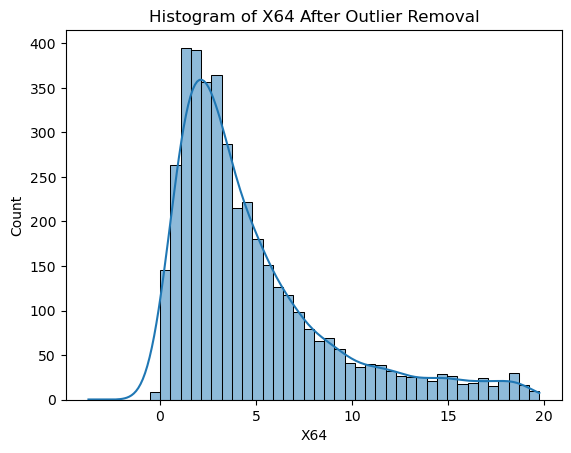

In [405]:
plt.figure(figsize=(6, 4))

for i, col in enumerate(df_cleaned_combined.columns[:-2]):
    plt.figure(i) 
    sns.boxplot(x=df_cleaned_combined[col])
    plt.title(f'Boxplot of {col} After Outlier Removal')
    plt.show()
    
    sns.histplot(df_cleaned_combined[col], kde=True)
    plt.title(f'Histogram of {col} After Outlier Removal')
    plt.show()

I found the distribution to be much smoother, but removing all outliers may lead to information loss. I decide to use Robust Scaler to handle to issue with outliers and normalise features into consistent scales in the Data Prepocessing section.

Correlation Analysis

The correlation analysis would be useful for later feature selection.

<Figure size 1500x1200 with 0 Axes>

<Axes: >

(array([ 0.5,  2.5,  4.5,  6.5,  8.5, 10.5, 12.5, 14.5, 16.5, 18.5, 20.5,
        22.5, 24.5, 26.5, 28.5, 30.5, 32.5, 34.5, 36.5, 38.5, 40.5, 42.5,
        44.5, 46.5, 48.5, 50.5, 52.5, 54.5, 56.5, 58.5, 60.5, 62.5, 64.5]),
 [Text(0.5, 0, 'X1'),
  Text(2.5, 0, 'X3'),
  Text(4.5, 0, 'X5'),
  Text(6.5, 0, 'X7'),
  Text(8.5, 0, 'X9'),
  Text(10.5, 0, 'X11'),
  Text(12.5, 0, 'X13'),
  Text(14.5, 0, 'X15'),
  Text(16.5, 0, 'X17'),
  Text(18.5, 0, 'X19'),
  Text(20.5, 0, 'X21'),
  Text(22.5, 0, 'X23'),
  Text(24.5, 0, 'X25'),
  Text(26.5, 0, 'X27'),
  Text(28.5, 0, 'X29'),
  Text(30.5, 0, 'X31'),
  Text(32.5, 0, 'X33'),
  Text(34.5, 0, 'X35'),
  Text(36.5, 0, 'X37'),
  Text(38.5, 0, 'X39'),
  Text(40.5, 0, 'X41'),
  Text(42.5, 0, 'X43'),
  Text(44.5, 0, 'X45'),
  Text(46.5, 0, 'X47'),
  Text(48.5, 0, 'X49'),
  Text(50.5, 0, 'X51'),
  Text(52.5, 0, 'X53'),
  Text(54.5, 0, 'X55'),
  Text(56.5, 0, 'X57'),
  Text(58.5, 0, 'X59'),
  Text(60.5, 0, 'X61'),
  Text(62.5, 0, 'X63'),
  Text(64.5, 0, 'B

(array([ 0.5,  2.5,  4.5,  6.5,  8.5, 10.5, 12.5, 14.5, 16.5, 18.5, 20.5,
        22.5, 24.5, 26.5, 28.5, 30.5, 32.5, 34.5, 36.5, 38.5, 40.5, 42.5,
        44.5, 46.5, 48.5, 50.5, 52.5, 54.5, 56.5, 58.5, 60.5, 62.5, 64.5]),
 [Text(0, 0.5, 'X1'),
  Text(0, 2.5, 'X3'),
  Text(0, 4.5, 'X5'),
  Text(0, 6.5, 'X7'),
  Text(0, 8.5, 'X9'),
  Text(0, 10.5, 'X11'),
  Text(0, 12.5, 'X13'),
  Text(0, 14.5, 'X15'),
  Text(0, 16.5, 'X17'),
  Text(0, 18.5, 'X19'),
  Text(0, 20.5, 'X21'),
  Text(0, 22.5, 'X23'),
  Text(0, 24.5, 'X25'),
  Text(0, 26.5, 'X27'),
  Text(0, 28.5, 'X29'),
  Text(0, 30.5, 'X31'),
  Text(0, 32.5, 'X33'),
  Text(0, 34.5, 'X35'),
  Text(0, 36.5, 'X37'),
  Text(0, 38.5, 'X39'),
  Text(0, 40.5, 'X41'),
  Text(0, 42.5, 'X43'),
  Text(0, 44.5, 'X45'),
  Text(0, 46.5, 'X47'),
  Text(0, 48.5, 'X49'),
  Text(0, 50.5, 'X51'),
  Text(0, 52.5, 'X53'),
  Text(0, 54.5, 'X55'),
  Text(0, 56.5, 'X57'),
  Text(0, 58.5, 'X59'),
  Text(0, 60.5, 'X61'),
  Text(0, 62.5, 'X63'),
  Text(0, 64.5, 'B

Text(0.5, 1.0, 'Correlation Heatmap')

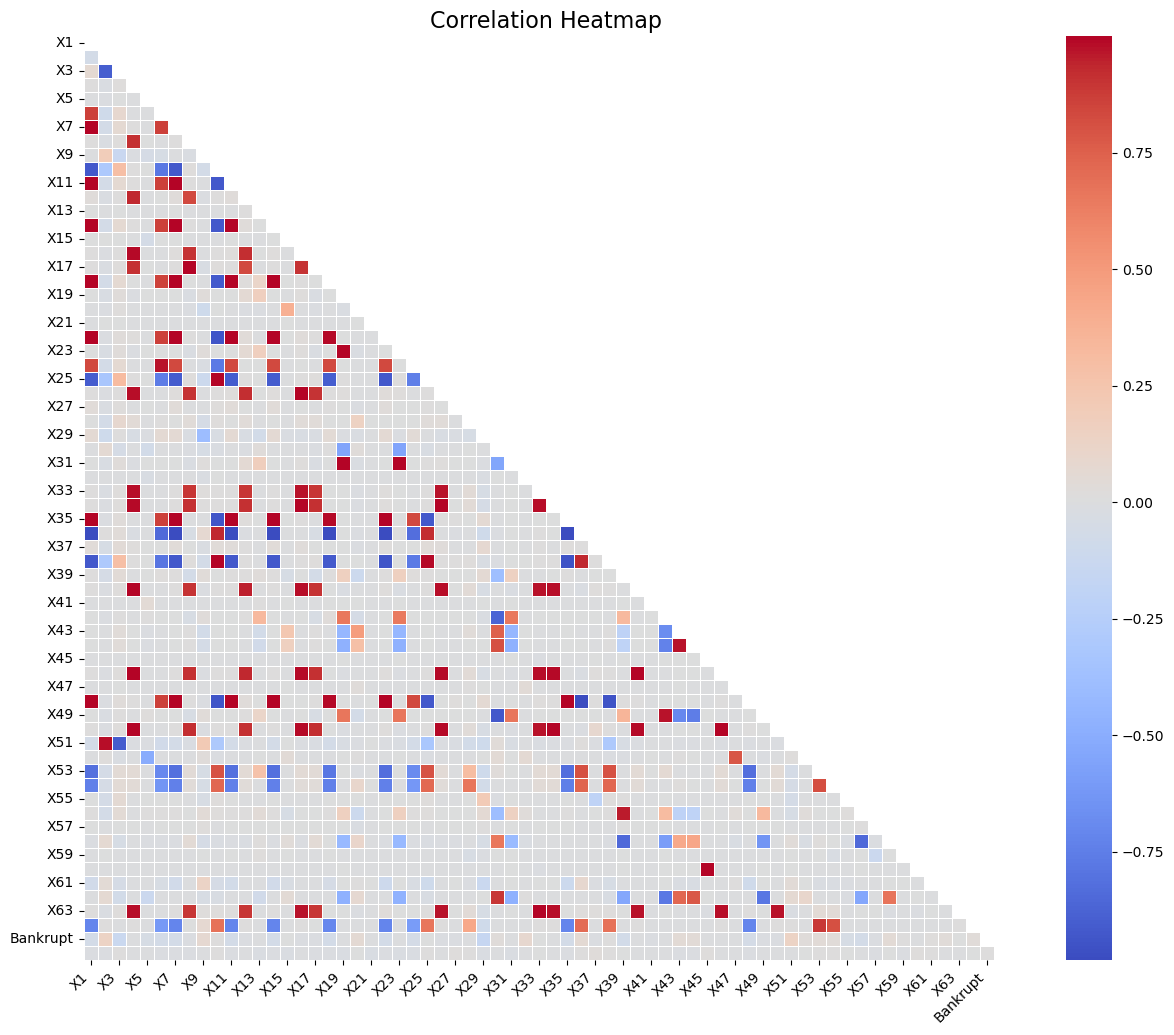

In [409]:
corr_matrix = df_copy.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(15, 12))

sns.heatmap(corr_matrix, mask=mask, annot=False, cmap="coolwarm", linewidths=0.5, square=True)
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0) 
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

Check for Class Imbalance

Class distribution:
 Bankrupt
0    4510
1     308
Name: count, dtype: int64


<Figure size 800x600 with 0 Axes>

<Axes: xlabel='Bankrupt'>

Text(0.5, 1.0, 'Class Distribution of Target Variable (Bankrupt)')

Text(0.5, 0, 'Class')

Text(0, 0.5, 'Count')

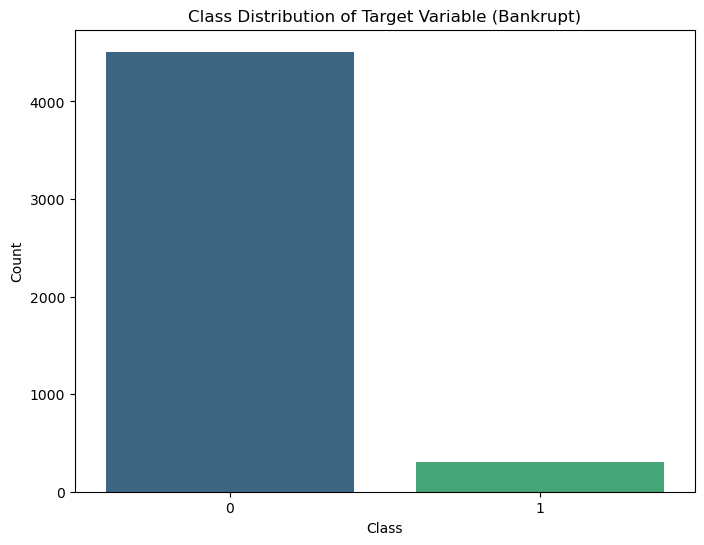

In [411]:
target_column = 'Bankrupt'
class_counts = df_copy[target_column].value_counts()
print("Class distribution:\n", class_counts)
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Class Distribution of Target Variable (Bankrupt)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

We got imbalanced targets. Then we will use oversampling or undersampling to deal with the issue later in data prepocessing.

Data Prepocessing 

Let's firstly split the target and features for easier analysis

In [415]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE

In [416]:
def split_features_target(df, feature_cols=64, target_col=64):
    X = df.iloc[:, :feature_cols]
    y = df.iloc[:, target_col]  
    return X, y  

Then, let's deal with missing values first and then do the normalization to deal with scale and outlier issue. Columns with 40% or more missing values would not be a good feature to be included in the model, and rows with more than 50% or more missing values would not be a good example to include in the training set. For the rest missing values, median imputation is preferred when there are outliers.

In [418]:
def handle_missing_data(df, target=None):
    row_threshold = df.shape[0] * 0.4
    col_threshold = df.shape[1] * 0.5
    valid_columns = df.columns[df.isnull().sum() < row_threshold]
    df = df[valid_columns]

    if target is not None:
        target = target[df.isnull().sum(axis=1) <= col_threshold]
        df = df[df.isnull().sum(axis=1) <= col_threshold]
   
    df = df.fillna(df.median())

    return df, target

Normalization Using Robust Scaler

In [420]:
def robust_normalize(df):
    scaler = RobustScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return X_scaled

Drop highly correlated features

In [422]:
def drop_high_corr_features(df, threshold=0.75):
    corr_matrix = df.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    df_reduced = df.drop(columns=to_drop)
    print(f"Features dropped due to high correlation: {to_drop}")
    print(f"Number of features dropped: {len(to_drop)}")
    return df_reduced

Synthesize all the data prepocessing steps and split the data into train and test.

In [424]:
def clean_data(df):
    X, y = split_features_target(df, feature_cols=64, target_col=64)
    X, y = handle_missing_data(X, y)
    X_scaled = robust_normalize(X)
    X_cleaned = drop_high_corr_features(X_scaled, threshold=0.75)
    return X_cleaned, y

# High accuracy on unbalanced data can be misleading, as it often comes 
# from correctly predicting the majority class (negatives), not true performance.
# def split_data_no_smote(df):
#     X_cleaned, y = clean_data(df)
    
#     # Split the data into training and testing sets (no SMOTE)
#     X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, test_size=0.2, random_state=42)
    
#     return X_train, X_test, y_train, y_test

def split_and_balance_data(df):
    X_cleaned, y = clean_data(df)
    X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, test_size=0.2, random_state=42)
    smote = SMOTE(random_state=123)
    X_smote, y_smote = smote.fit_resample(X_train, y_train)
    return X_smote, X_test, y_smote, y_test

Figure out how many features we left after we drop all highly correlated features and see if we solve the multicollinearity issue.

Features dropped due to high correlation: ['X3', 'X6', 'X7', 'X8', 'X10', 'X11', 'X12', 'X14', 'X16', 'X17', 'X18', 'X22', 'X23', 'X24', 'X25', 'X26', 'X31', 'X33', 'X34', 'X35', 'X36', 'X38', 'X40', 'X42', 'X44', 'X46', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X56', 'X58', 'X60', 'X62', 'X63', 'X64']
Number of features dropped: 39


<Axes: >

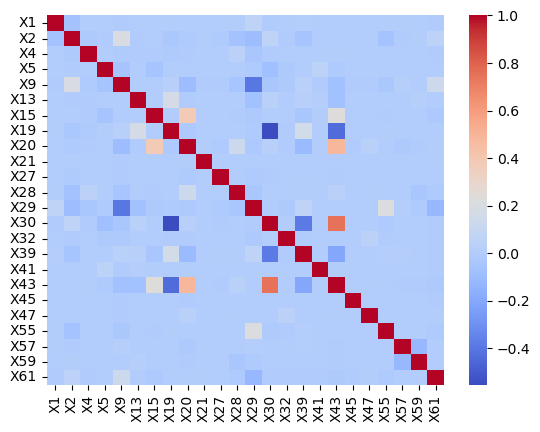

In [426]:
X_heatmap, y_heatmap = clean_data(df_copy)
sns.heatmap(X_heatmap.corr(), annot=False, cmap="coolwarm")

Model Evaluation Metrics

In [428]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, f1_score

In [429]:
def evaluate_model_performance(y_true, y_pred, set_name="Data"):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')

    print(f"\n{set_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

Model Fitting

In [431]:
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
!pip install xgboost
import xgboost as xgb

Baseline model: Logistic Regression

In [433]:
X_train, X_test, y_train, y_test = split_and_balance_data(data)

model = LogisticRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

evaluate_model_performance(y_train, y_train_pred, set_name="Training Data")
evaluate_model_performance(y_test, y_pred, set_name="Testing Data")

Features dropped due to high correlation: ['X3', 'X6', 'X7', 'X8', 'X10', 'X11', 'X12', 'X14', 'X16', 'X17', 'X18', 'X22', 'X23', 'X24', 'X25', 'X26', 'X31', 'X33', 'X34', 'X35', 'X36', 'X38', 'X40', 'X42', 'X44', 'X46', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X56', 'X58', 'X60', 'X62', 'X63', 'X64']
Number of features dropped: 39


LogisticRegression()


Training Data Performance:
Accuracy: 0.7475
Precision: 0.7146
Recall: 0.8241
F1 Score: 0.7655

Testing Data Performance:
Accuracy: 0.6587
Precision: 0.1471
Recall: 0.7714
F1 Score: 0.2471


KNN Model

In [435]:
X_train, X_test, y_train, y_test = split_and_balance_data(data)
pca_knn_pipeline = Pipeline([
    ('pca', PCA()),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'pca__n_components': [5, 10, 15, 20], 
    'knn__n_neighbors': [3, 5, 7, 9]   
}

grid_search = GridSearchCV(pca_knn_pipeline, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")


y_train_pred = grid_search.predict(X_train)
y_pred = grid_search.predict(X_test)

evaluate_model_performance(y_train, y_train_pred, set_name="Training Data")
evaluate_model_performance(y_test, y_pred, set_name="Testing Data")

Features dropped due to high correlation: ['X3', 'X6', 'X7', 'X8', 'X10', 'X11', 'X12', 'X14', 'X16', 'X17', 'X18', 'X22', 'X23', 'X24', 'X25', 'X26', 'X31', 'X33', 'X34', 'X35', 'X36', 'X38', 'X40', 'X42', 'X44', 'X46', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X56', 'X58', 'X60', 'X62', 'X63', 'X64']
Number of features dropped: 39


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [3, 5, 7, 9],
                         'pca__n_components': [5, 10, 15, 20]},
             scoring='recall')

Best Parameters: {'knn__n_neighbors': 3, 'pca__n_components': 20}

Training Data Performance:
Accuracy: 0.9491
Precision: 0.9183
Recall: 0.9859
F1 Score: 0.9509

Testing Data Performance:
Accuracy: 0.7956
Precision: 0.1710
Recall: 0.4714
F1 Score: 0.2510


SVM Model

In [437]:
# Commented out due to running time reason
# svm_model = SVC(random_state=42)
# param_grid = {
#     'C': [0.1, 1, 10, 100],             
#     'gamma': ['scale', 'auto', 0.01, 0.1], 
#     'kernel': ['linear', 'rbf', 'poly']
# }


# grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# best_params = grid_search.best_params_
# print(f"Best Parameters: {best_params}")

# best_model = grid_search.best_estimator_


# y_pred = best_model.predict(X_test)
# evaluate_model_performance(y_test, y_pred, set_name="Test Data")


# y_train_pred = best_model.predict(X_train)
# evaluate_model_performance(y_train, y_train_pred, set_name="Training Data")

In [438]:
# Commented out because running time issue
# X_train, X_test, y_train, y_test = split_and_balance_data(data)
# svm_model_after_gridsearch = SVC(C=1, gamma=0.1, kernel="poly")
# svm_model_after_gridsearch.fit(X_train, y_train)

# y_pred = svm_model_after_gridsearch.predict(X_test)
# evaluate_model_performance(y_test, y_pred, set_name="Test Data")

# y_train_pred = svm_model_after_gridsearch.predict(X_train)
# evaluate_model_performance(y_train, y_train_pred, set_name="Training Data")

Decision Tree

In [440]:
X_train, X_test, y_train, y_test = split_and_balance_data(data)
decision_tree_model = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [3, 5, 10, 15, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'criterion': ['gini', 'entropy']  
}

grid_search = GridSearchCV(decision_tree_model, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

evaluate_model_performance(y_test, y_pred, set_name="Test Data")

y_train_pred = best_model.predict(X_train)
evaluate_model_performance(y_train, y_train_pred, set_name="Training Data")

Features dropped due to high correlation: ['X3', 'X6', 'X7', 'X8', 'X10', 'X11', 'X12', 'X14', 'X16', 'X17', 'X18', 'X22', 'X23', 'X24', 'X25', 'X26', 'X31', 'X33', 'X34', 'X35', 'X36', 'X38', 'X40', 'X42', 'X44', 'X46', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X56', 'X58', 'X60', 'X62', 'X63', 'X64']
Number of features dropped: 39


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10, 15, 40, None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10]},
             scoring='recall')

Best Parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}

Test Data Performance:
Accuracy: 0.8558
Precision: 0.2715
Recall: 0.5857
F1 Score: 0.3710

Training Data Performance:
Accuracy: 0.9873
Precision: 0.9765
Recall: 0.9986
F1 Score: 0.9874


Random Forest Model

In [442]:
# Commented out due to running time issue
# rf_model = RandomForestClassifier(random_state=42)

# param_grid = {
#     'n_estimators': [50, 100, 200],  
#     'max_depth': [10, 15, 20, 25, 30, None],  
#     'min_samples_split': [2, 5, 10],  
#     'min_samples_leaf': [1, 2, 4],   
#     'max_features': ['sqrt', 'log2'], 
#     'bootstrap': [True, False]       
# }

# grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='recall', n_jobs=-1)

# grid_search.fit(X_train, y_train)

# best_params = grid_search.best_params_
# print(f"Best Parameters: {best_params}")

# best_rf_model = grid_search.best_estimator_

# y_pred = best_rf_model.predict(X_test)
# evaluate_model_performance(y_test, y_pred, set_name="Test Data")

# y_train_pred = best_rf_model.predict(X_train)
# evaluate_model_performance(y_train, y_train_pred, set_name="Training Data")

In [443]:
X_train, X_test, y_train, y_test = split_and_balance_data(data)
best_rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=25,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features="sqrt",
    bootstrap=True,
    random_state=42,
)

best_rf_model.fit(X_train, y_train)

y_pred = best_rf_model.predict(X_test)
evaluate_model_performance(y_test, y_pred, set_name="Test Data")
y_train_pred = best_rf_model.predict(X_train)
evaluate_model_performance(y_train, y_train_pred, set_name="Training Data")

Features dropped due to high correlation: ['X3', 'X6', 'X7', 'X8', 'X10', 'X11', 'X12', 'X14', 'X16', 'X17', 'X18', 'X22', 'X23', 'X24', 'X25', 'X26', 'X31', 'X33', 'X34', 'X35', 'X36', 'X38', 'X40', 'X42', 'X44', 'X46', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X56', 'X58', 'X60', 'X62', 'X63', 'X64']
Number of features dropped: 39


RandomForestClassifier(max_depth=25, min_samples_leaf=4, min_samples_split=10,
                       random_state=42)


Test Data Performance:
Accuracy: 0.9160
Precision: 0.4353
Recall: 0.5286
F1 Score: 0.4774

Training Data Performance:
Accuracy: 0.9895
Precision: 0.9818
Recall: 0.9975
F1 Score: 0.9896


XGBoost Model

In [445]:
X_train, X_test, y_train, y_test = split_and_balance_data(data)
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],        
    'max_depth': [3, 5, 7],               
    'min_child_weight': [1, 3, 5],        
    'gamma': [0, 0.1, 0.2],                 
    'subsample': [0.8, 1.0],              
    'colsample_bytree': [0.8, 1.0],       
}


grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(random_state=42),
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=1
)


grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

best_xgb_model = grid_search.best_estimator_
    
evaluate_model_performance(y_test, y_pred, set_name="Test Data")

y_train_pred = best_xgb_model.predict(X_train)
evaluate_model_performance(y_train, y_train_pred, set_name="Training Data")

Features dropped due to high correlation: ['X3', 'X6', 'X7', 'X8', 'X10', 'X11', 'X12', 'X14', 'X16', 'X17', 'X18', 'X22', 'X23', 'X24', 'X25', 'X26', 'X31', 'X33', 'X34', 'X35', 'X36', 'X38', 'X40', 'X42', 'X44', 'X46', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X56', 'X58', 'X60', 'X62', 'X63', 'X64']
Number of features dropped: 39
Fitting 5 folds for each of 972 candidates, totalling 4860 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0], 'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1.0]},
             scoring='recall', verbose=1)

Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}

Test Data Performance:
Accuracy: 0.9160
Precision: 0.4353
Recall: 0.5286
F1 Score: 0.4774

Training Data Performance:
Accuracy: 0.9994
Precision: 0.9992
Recall: 0.9997
F1 Score: 0.9994


I found the XGBClassifier would do the best job.

In [447]:
def MyModel(data, other={}):
    """
    Parameters
    -----------
    data: a Pandas DataFrame
    other: a dict
        You can use this to pass any other arguments you find are necessary
        
    Returns
    -------
    pred: an array of predicted values
        The number of elements (i.e., predictions) is equal to the number of examples in the 'data' parameter
            i.e., one prediction per example
    """
    
    # The function should create an array of predictions; we initialize it to the empty array for convenience
    pred = []

    # YOUR CODE HERE
    holdout_data = data.apply(pd.to_numeric, errors='coerce')  
    holdout_data, _ = handle_missing_data(holdout_data, None) 
    holdout_data_scaled = robust_normalize(holdout_data)  
    features_to_drop = ['X3', 'X6', 'X7', 'X8', 'X10', 
                        'X11', 'X12', 'X14', 'X16', 'X17', 
                        'X18', 'X22', 'X23', 'X24', 'X25', 
                        'X26', 'X31', 'X33', 'X34', 'X35',
                        'X36', 'X38', 'X40', 'X42', 'X44', 
                        'X46', 'X48', 'X49', 'X50', 'X51',
                        'X52', 'X53', 'X54', 'X56', 'X58', 
                        'X60', 'X62', 'X63', 'X64']
    holdout_data_cleaned = holdout_data_scaled.drop(columns=features_to_drop, errors='ignore')
    pred = best_xgb_model.predict(holdout_data_cleaned)
    
    return pred

## Submission guidelines

Although your notebook may contain many models (e.g., due to your iterative development)
we will only evaluate a single model.

So choose one (explain why !) and obey the following guidelines.

The objective of creating the guideline is to simplify the evaluation of your model.

We have specified this by requiring you to implement a function called `MyModel`
- which takes an unlabeled holdout dataset (one example per row)
- and returns an array of predictions (one per holdout example)

We will evaluate your model by passing a holdout dataset into your implemention of `MyModel`

- obtaining predictions
- evaluating the predictions against metrics such as Accuracy and Recall











To be specific:

You will implement the body of a subroutine `MyModel`

The subroutine
- takes as argument a Pandas DataFrame 
    - Each row is an example on which to predict
    - The features of the example are elements of the row
- Performs predictions on each example
- Returns an array of predictions with a one-to-one correspondence with the examples in the test set

Here is what `MyModel` should look like:


    def MyModel(data, other={}):
        """
        Parameters
        -----------
        data: a Pandas DataFrame
        other: a dict
            You can use this to pass any other arguments you find are necessary
            
        Returns
        -------
        pred: an array of predicted values
            The number of elements (i.e., predictions) is equal to the number of examples in the 'data' parameter
                i.e., one prediction per example
        """
        
        # The function should create an array of predictions; we initialize it to the empty array for convenience
        pred = []
   
        # YOUR CODE HERE
        
        return pred

Your code should follow the comment `# YOUR CODE HERE`

We will evaluate your model against the holdout data
- By reading the holdout examples `X_hold` (as above)
- Calling `y_hold_pred = MyModel(X_hold, other)` to get the predictions
- Comparing the predicted values `y_hold_pred` against the true labels `y_hold` which are known only to the instructors

See the following cell as an illustration

**Remember**

The holdout data is in the same format as the one we used for training
- Except that it has no attribute for the target
- So you will need to perform all the transformations on the holdout data
    - As you did on the training data
    - Including turning the string representation of numbers into actual numeric data types

All of this work *must* be performed within the body of the `MyModel` routine you will write

We will grade you by comparing the predictions array you create to the answers known to us.

# Check your work: predict and evaluate metrics on *your* test examples

Although only the instructors have the correct labels for the holdout dataset, you may want
to create your own test dataset on which to evaluate your out of sample metrics.

If you choose to do so, you can evaluate your models using the same metrics that the instructors will use.

- Test whether your implementation of `MyModel` works
- See the metrics  your model produces

In [455]:
name = "XGBoost Bankruptcy Predictor"
other = {}
y_test_pred = MyModel(X_test, other)

accuracy_test = accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred, pos_label=1, average="binary")
precision_test = precision_score(y_test, y_test_pred, pos_label=1, average="binary")

print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            p=precision_test
                                                                            )
         )

	XGBoost Bankruptcy Predictor Accuracy: 90.7%, Recall 61.4%, Precision 40.6%
